### DoppelGANger
* Use Gretel's opensourse model
* The Timeseries DGAN module contains a PyTorch implementation of the DoppelGANger model, see https://arxiv.org/abs/1909.13403 for a detailed description of the model.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# !git clone https://github.com/gretelai/gretel-synthetics.git

Cloning into 'gretel-synthetics'...
remote: Enumerating objects: 2424, done.
remote: Counting objects: 100% (820/820), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 2424 (delta 504), reused 671 (delta 444), pack-reused 1604
Receiving objects: 100% (2424/2424), 2.35 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (1408/1408), done.


### Installation & Import

In [ ]:
!pip install gretel-synthetics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gretel-synthetics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

from glob import glob
from datetime import timedelta

### Import & Unzip Data

In [ ]:
%cd /content

/content


In [ ]:
# 소프트링크
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive

In [ ]:
# 압축풀기
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

### Data Load & Preprocessing

In [ ]:
def make_traindata_dgan(input_dir_list):
  train = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train = pd.concat([train, train_df])
  train['obs_time'] = pd.to_datetime(train['obs_time'])
  train['datetime'] = train['obs_time'] + train['DAT'].apply(lambda x: timedelta(days=x))

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  train.loc[train['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train.loc[train['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # column 삭제
  col_names = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  train = train[['datetime'] + col_names]

  return train

### 1-day training samples

1. Train data: CASE_01~28.csv

In [ ]:
input_dir_list = sorted(glob('/content/dataset/train_input/*.csv'))
train_df = make_traindata_dgan(input_dir_list)

In [ ]:
features = train_df.drop(columns='datetime').to_numpy()
features = features.reshape(-1, 24, features.shape[1])
print(features.shape)

(784, 24, 4)


In [ ]:
# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=24,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)


In [ ]:
# Generate synthetic data
_, synthetic_features = model.generate_numpy(1000)

In [ ]:
# Show a few of the 1-day training samples
xaxis_1day = train_df["datetime"][0:24]

def plot_day(f):
  columns = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  titles = ['Temperatture', 'Humidity', 'ec', 'co2']
  colors = ['red', 'blue', 'orange', 'green']

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
  axs = axs.ravel(order='C')
  for i, c in enumerate(columns):
    axs[i].plot(xaxis_1day, f[:,i], label=titles[i], color=colors[i])
    axs[i].legend()
    axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(titles[i])
  plt.tight_layout()
  plt.show()

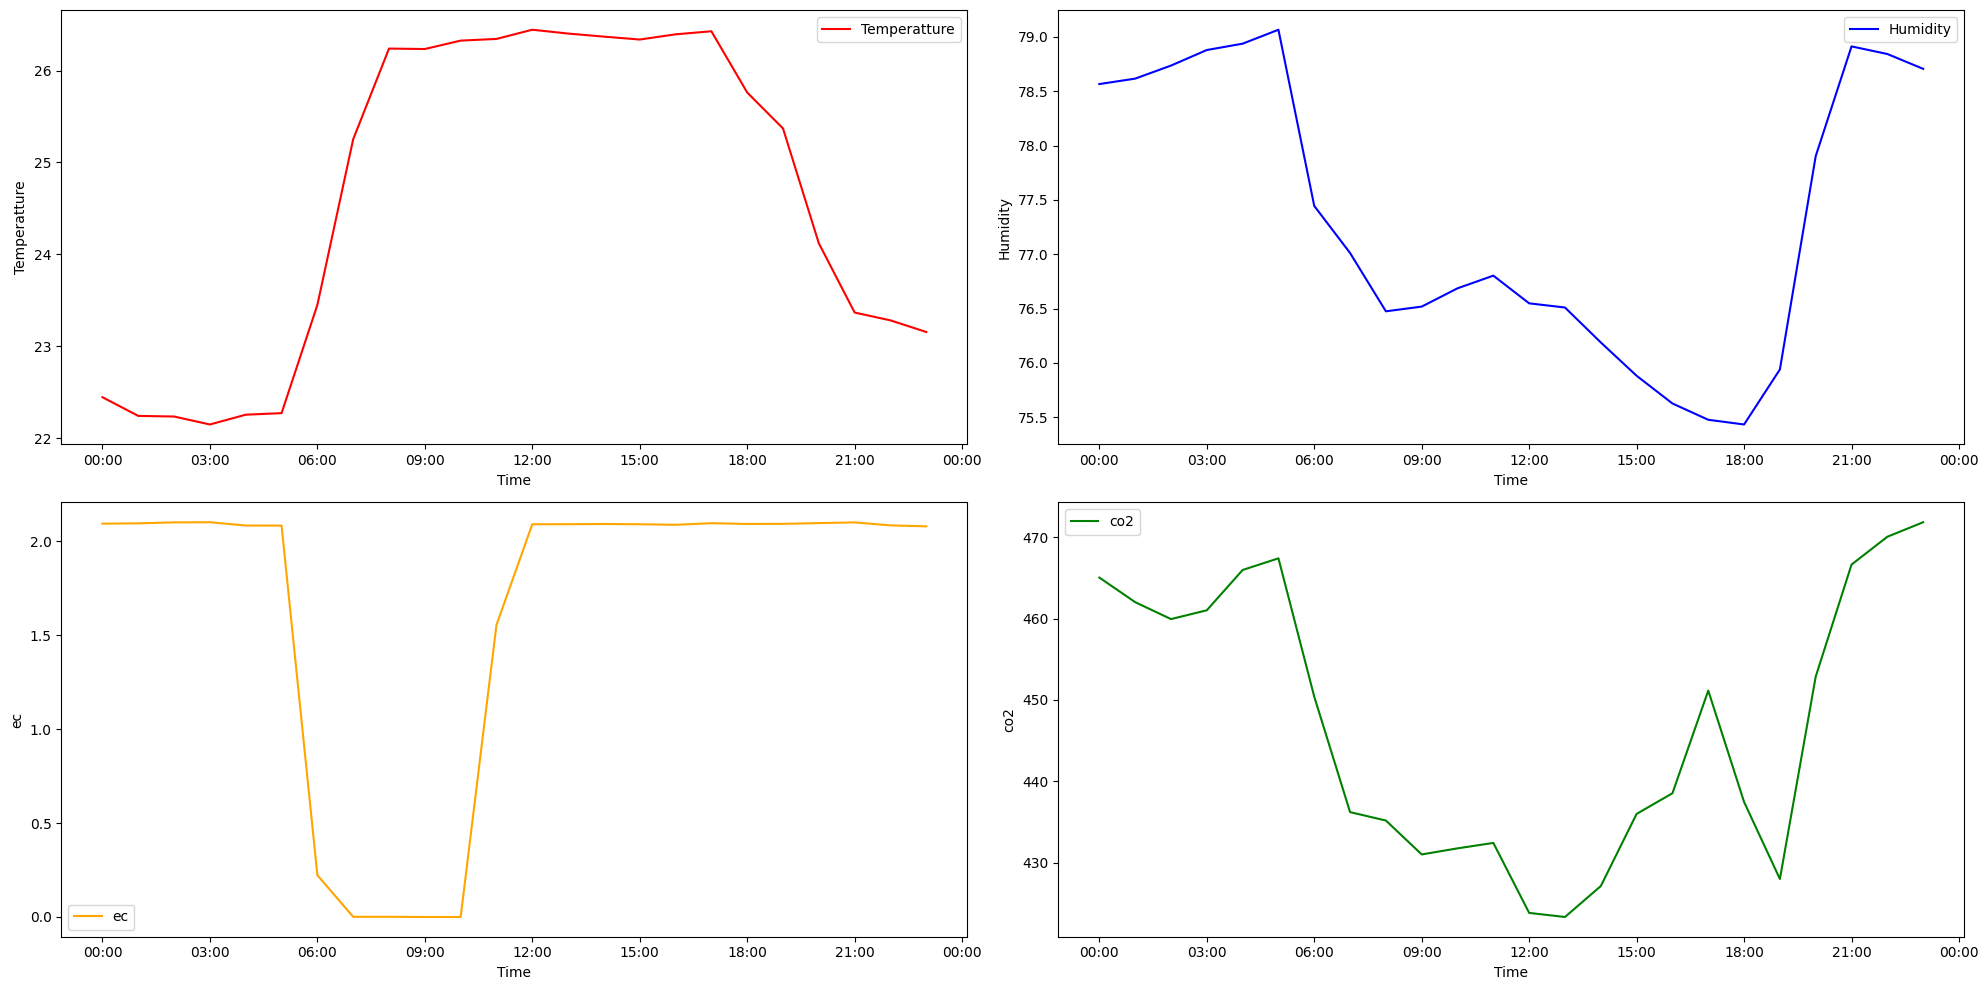

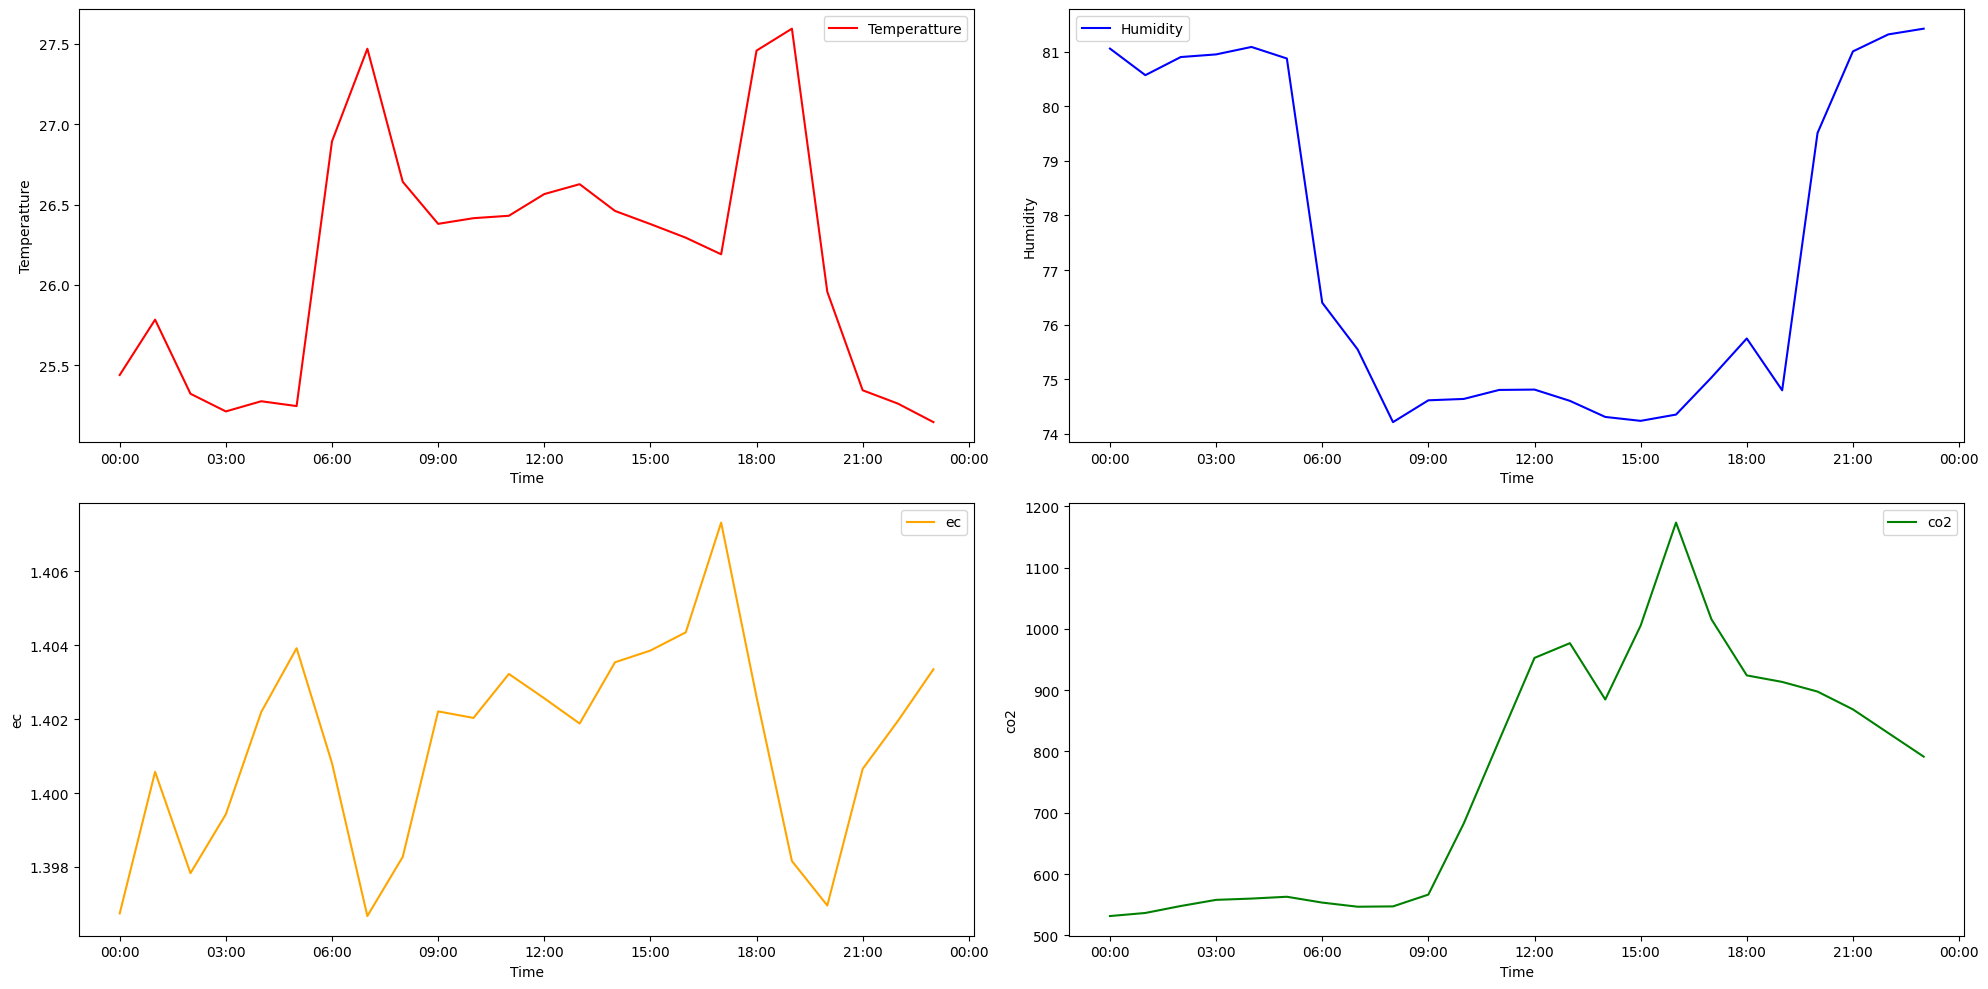

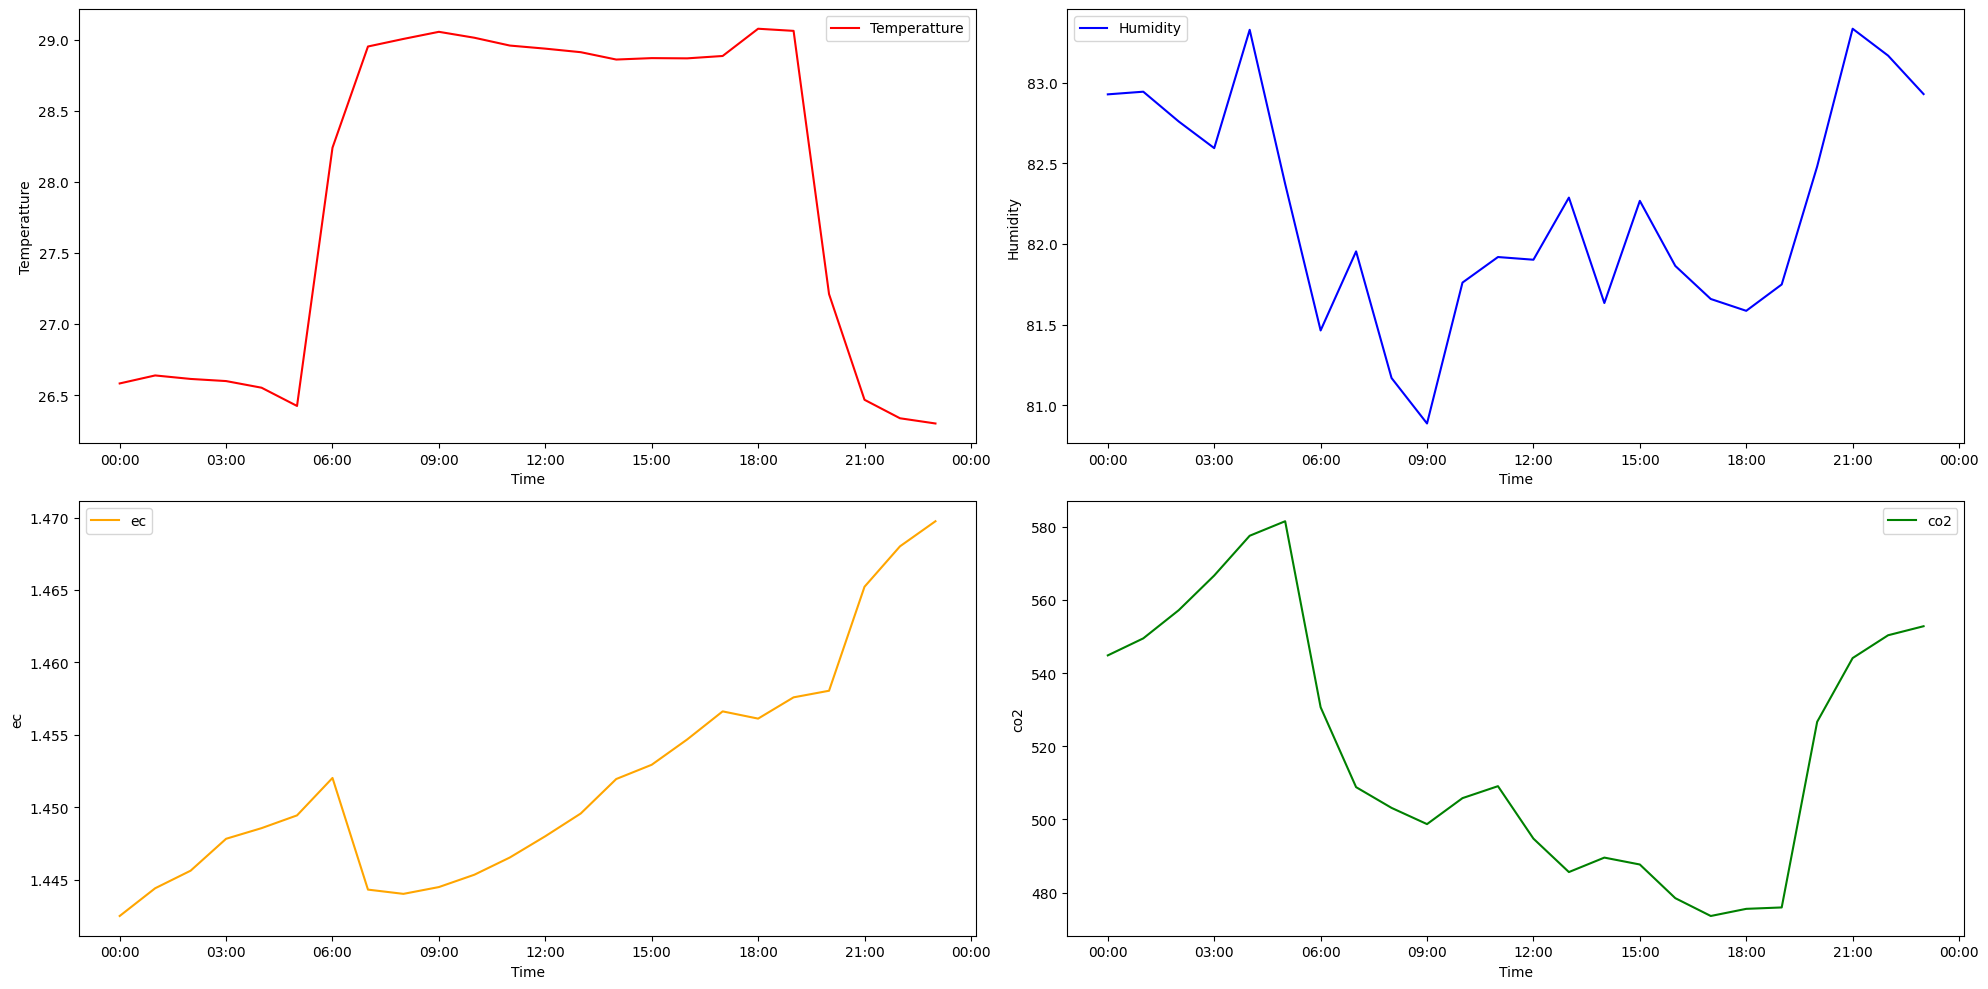

In [ ]:
%matplotlib inline
plot_day(features[125,:,:])
plot_day(features[3,:,:])
plot_day(features[21,:,:])

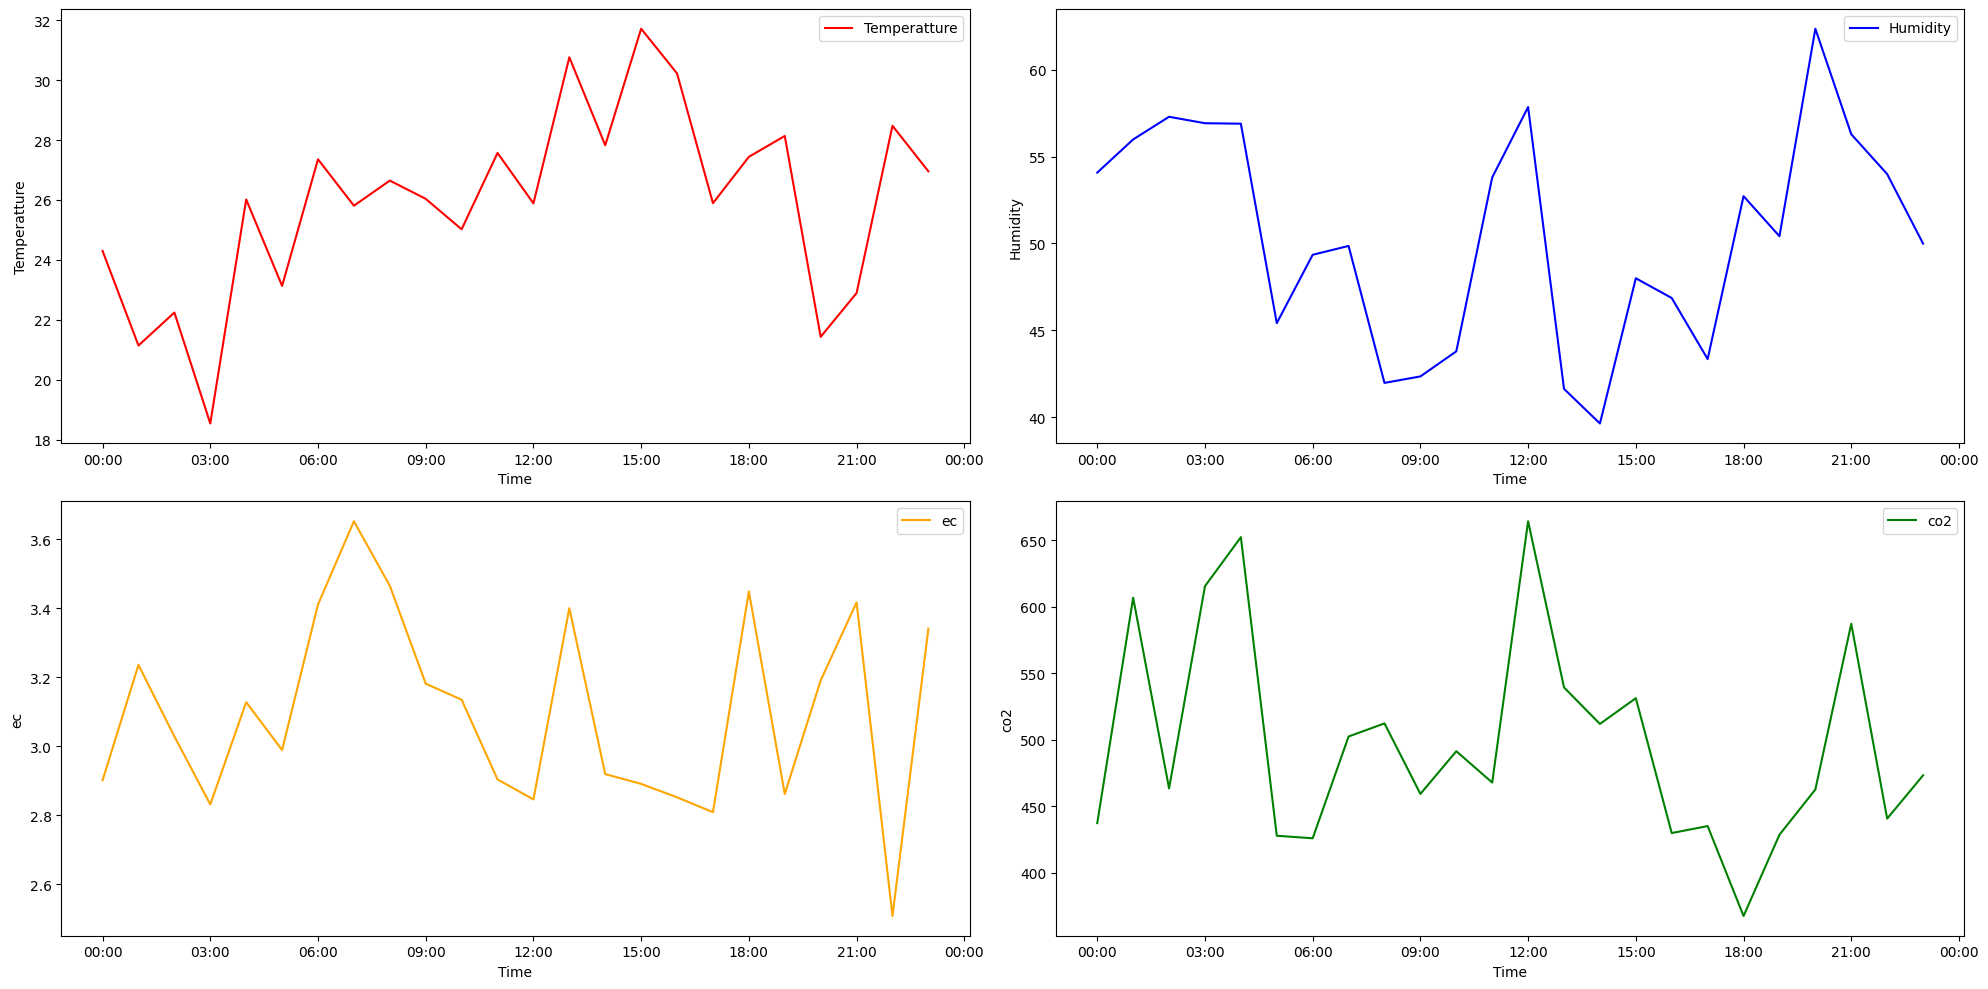

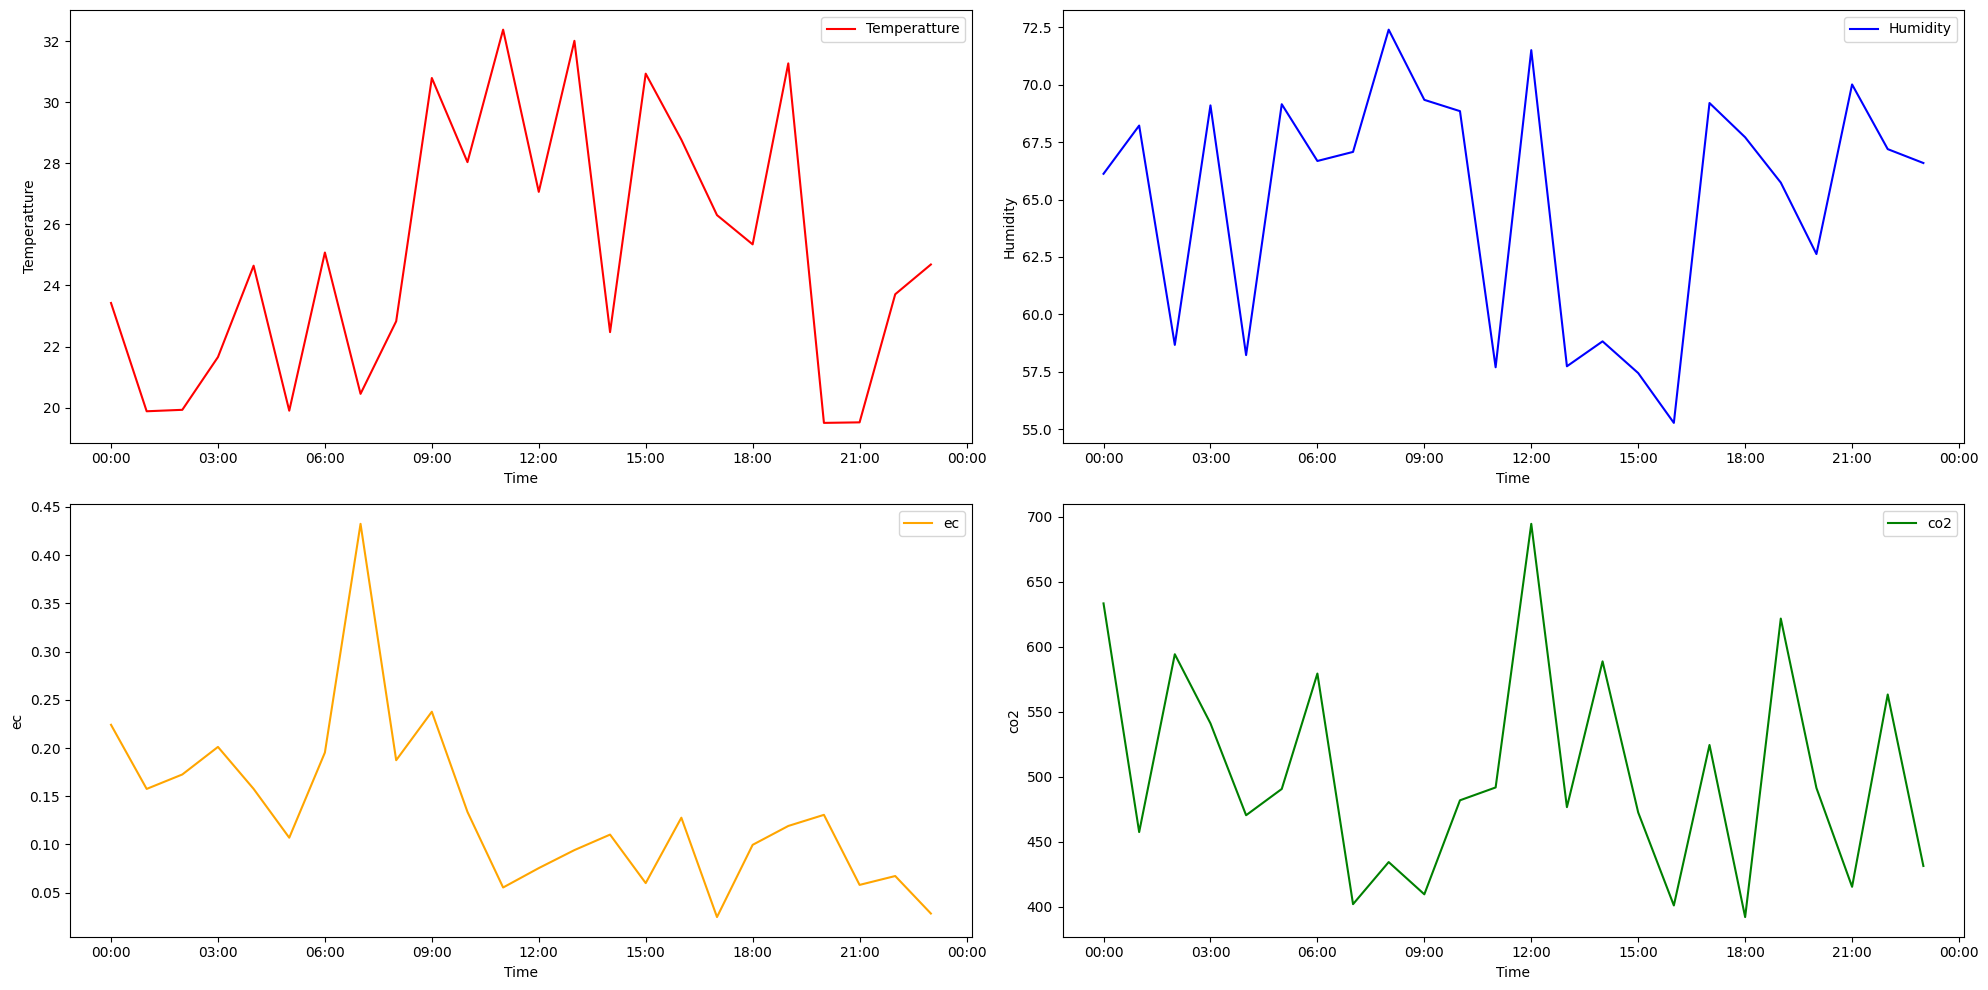

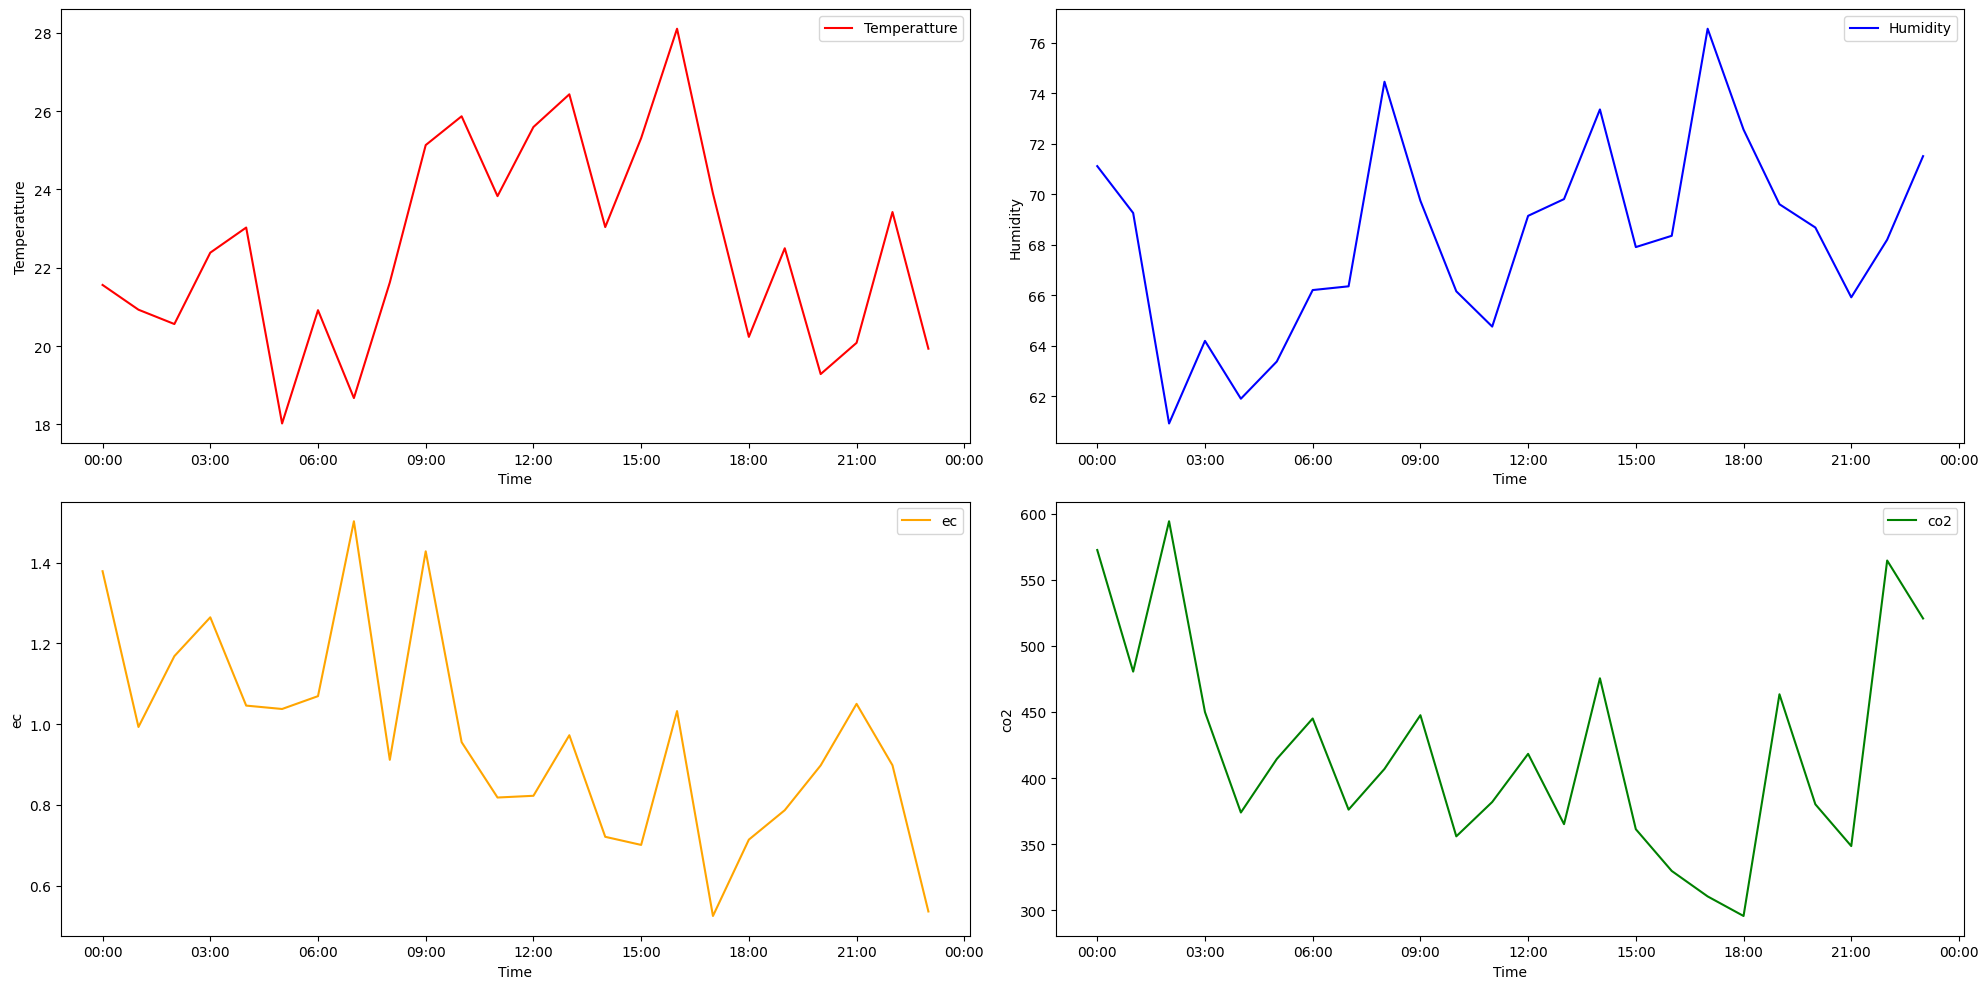

In [ ]:
# Show some synthetic 1-day samples
plot_day(synthetic_features[825,:,:])
plot_day(synthetic_features[42,:,:])
plot_day(synthetic_features[496,:,:])

# Overall trends are similar to training samples, but with more local noise

2. Train data: CASE_20.csv

In [ ]:
input_dir_list1 = sorted(glob('/content/dataset/train_input/CASE_20.csv'))
train_df1 = make_traindata_dgan(input_dir_list1)

In [ ]:
features1 = train_df1.drop(columns='datetime').to_numpy()
features1 = features1.reshape(-1, 24, features1.shape[1])
print(features1.shape)

(28, 24, 4)


In [ ]:
# Train DGAN model
model1 = DGAN(DGANConfig(
    max_sequence_len=features1.shape[1],
    sample_len=4,
    batch_size=min(1000, features1.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model1.train_numpy(
    features1,
    feature_types=[OutputType.CONTINUOUS] * features1.shape[2],
)


In [ ]:
model1.save(file_name='/mydrive/model_param/CASE_20/dgan/synthesizer_dgan.pkl')

In [ ]:
# Generate synthetic data
_, synthetic_features1 = model1.generate_numpy(features1.shape[0])
print(synthetic_features1.shape)

(28, 24, 4)


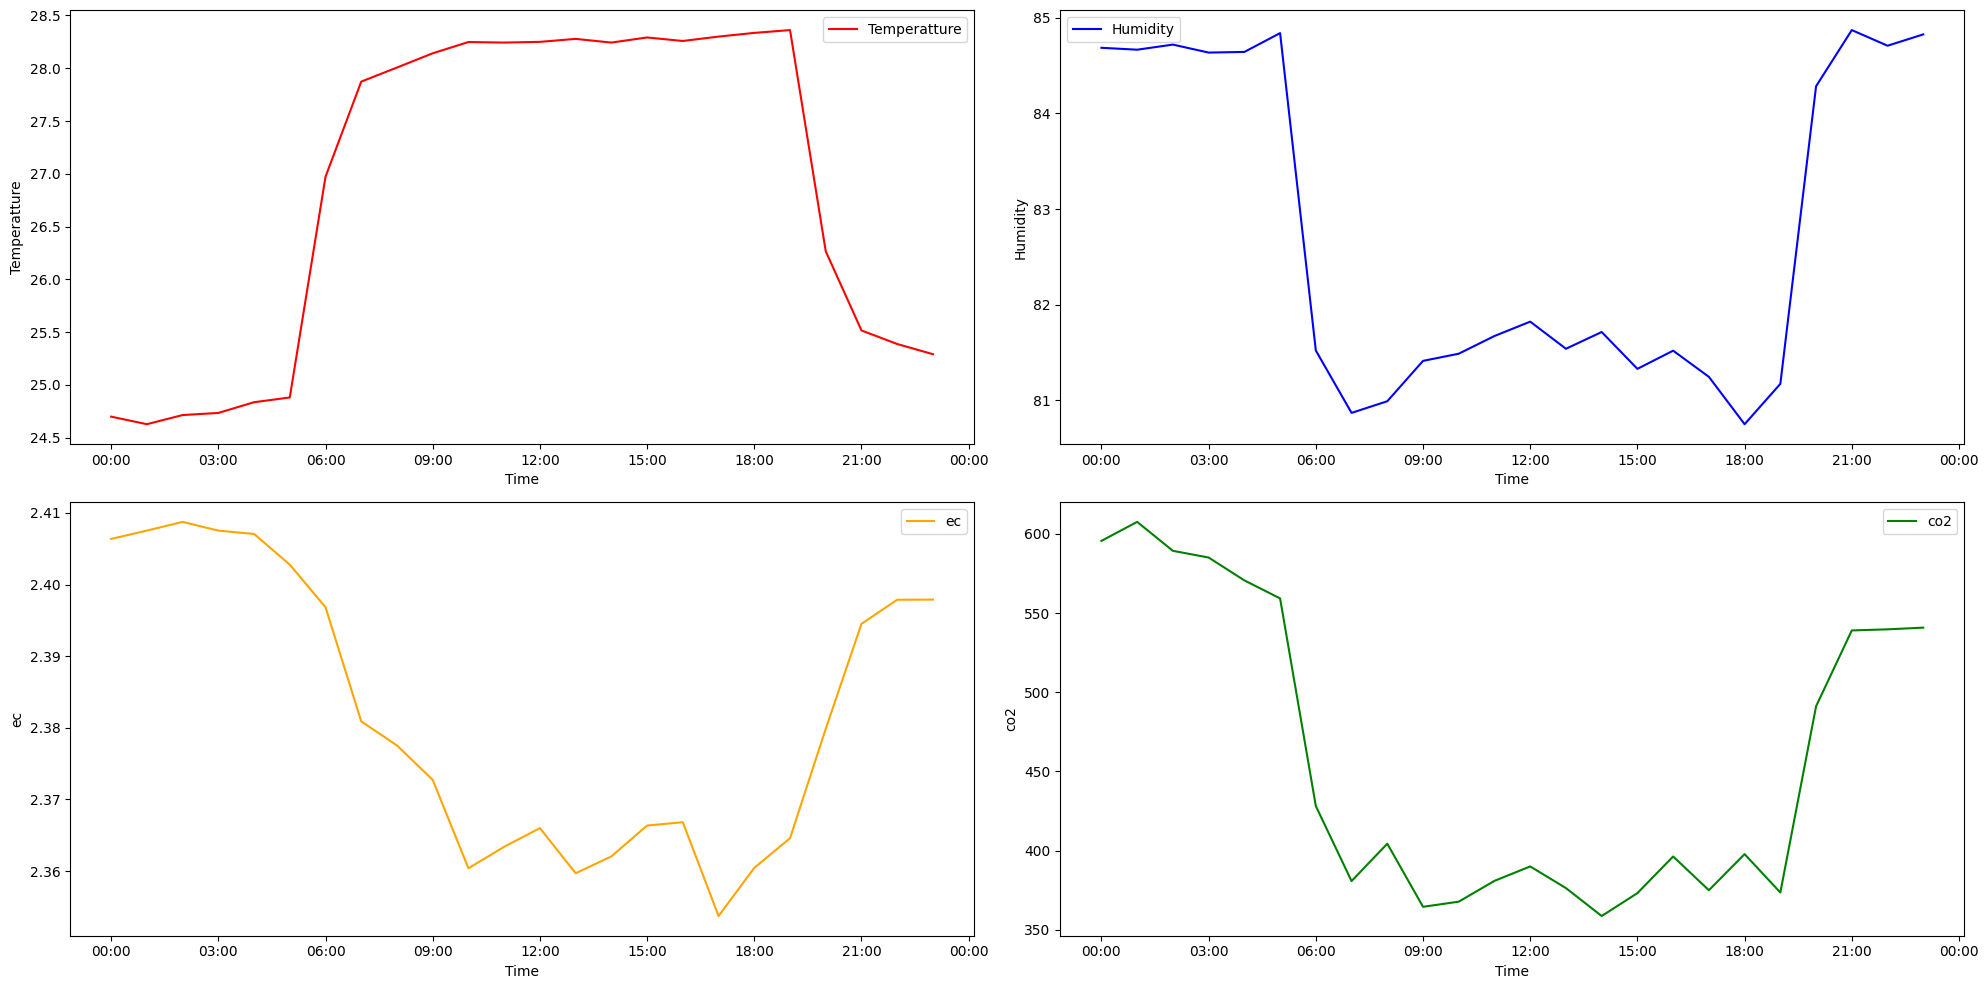

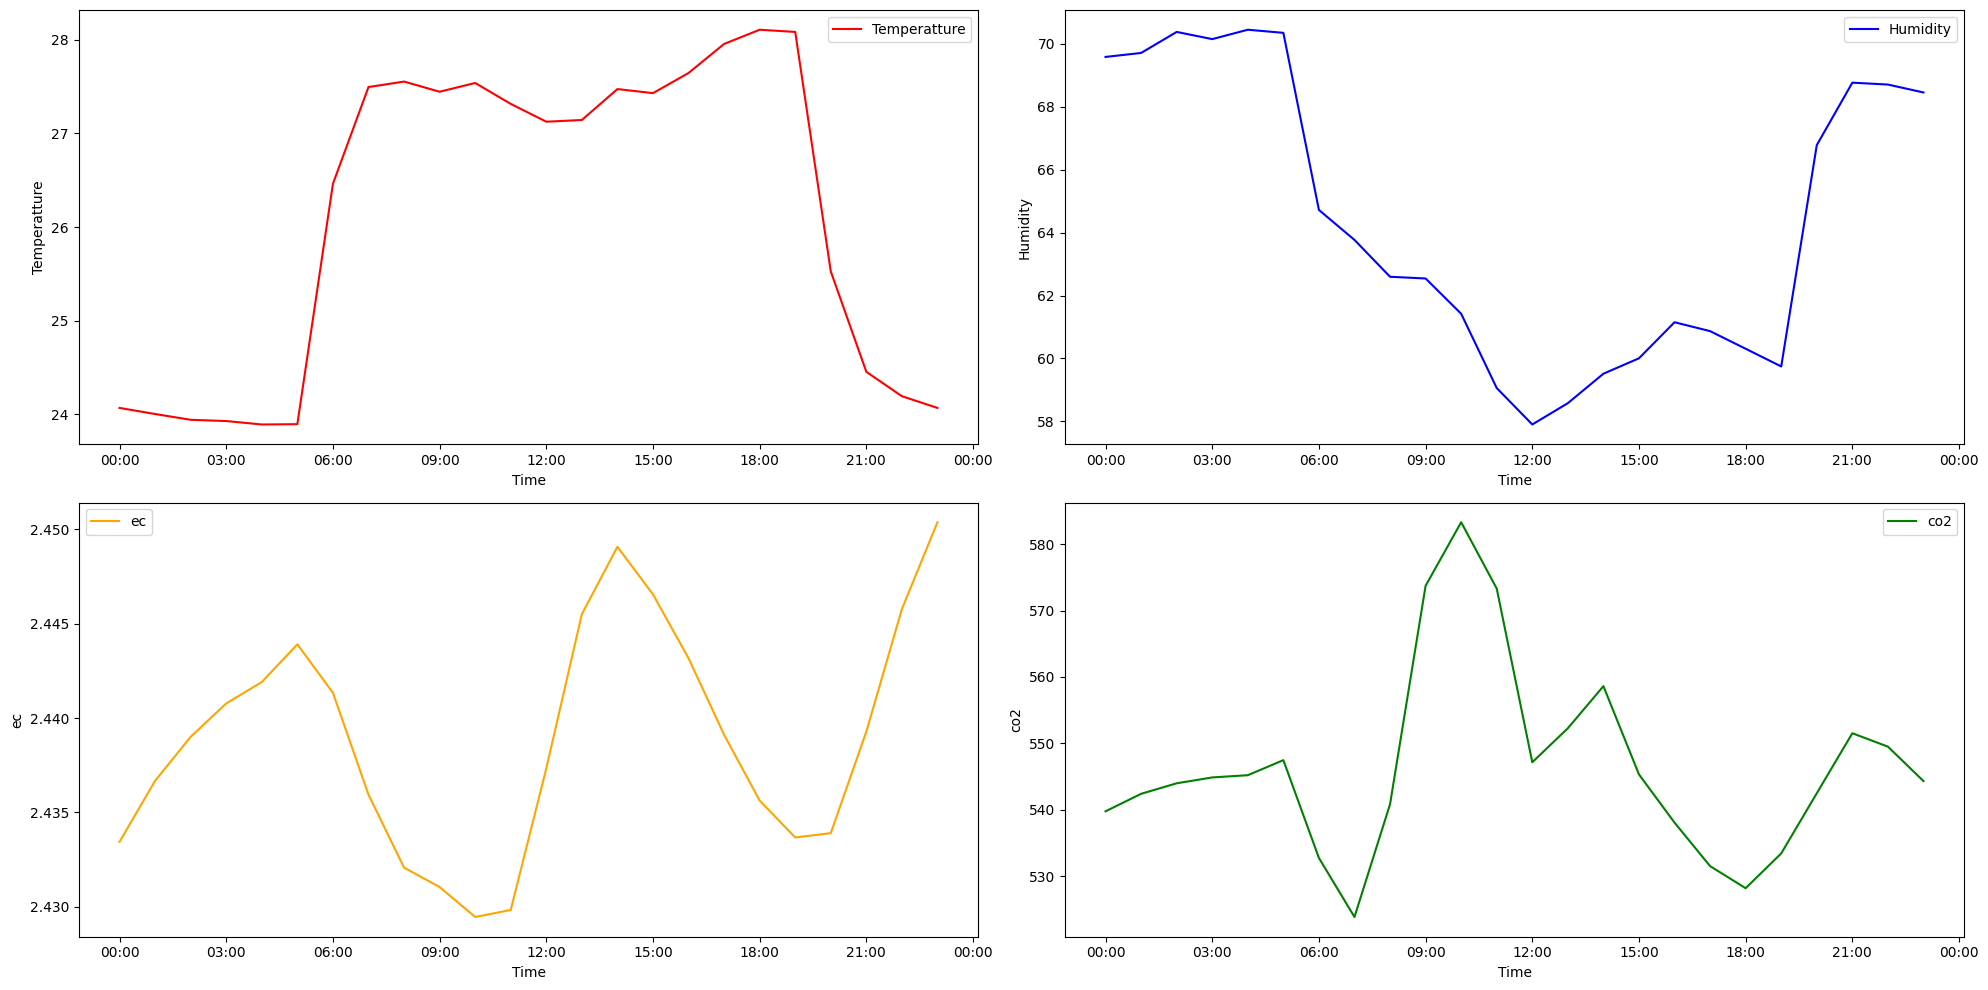

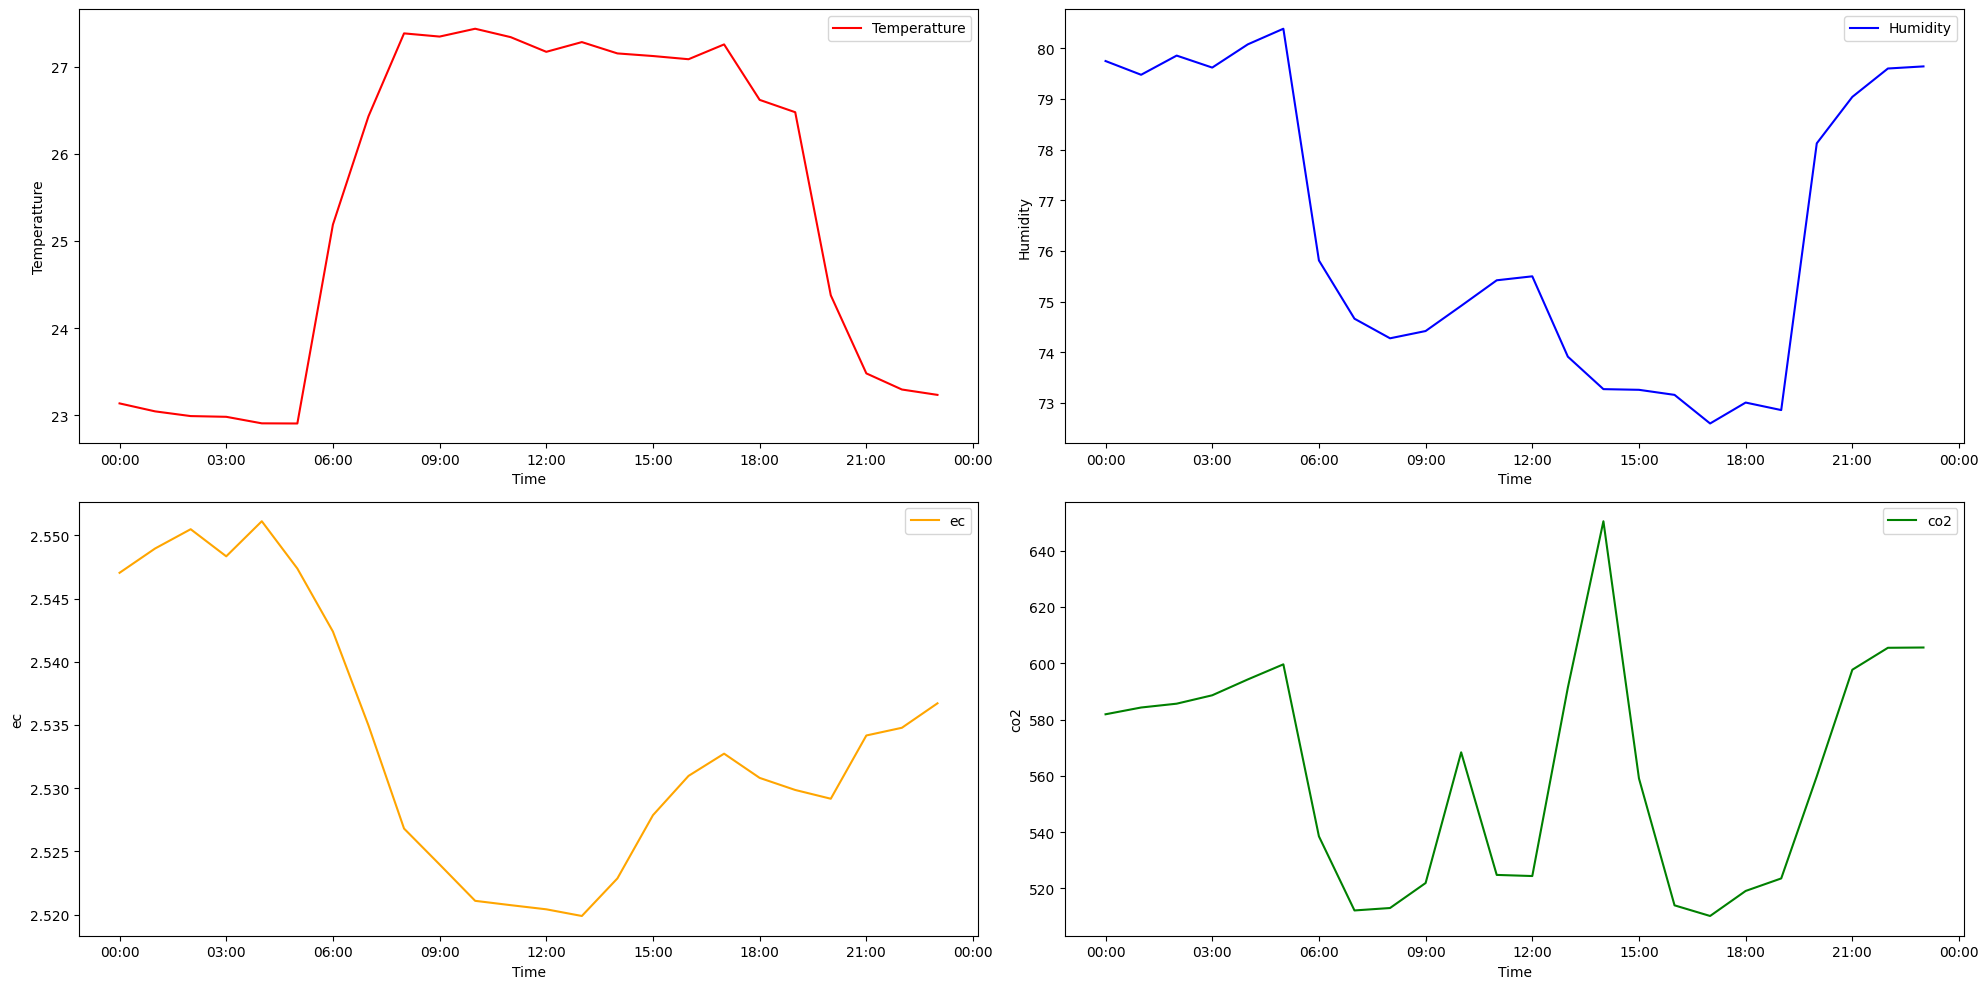

In [ ]:
plot_day(features1[20,:,:])
plot_day(features1[5,:,:])
plot_day(features1[12,:,:])

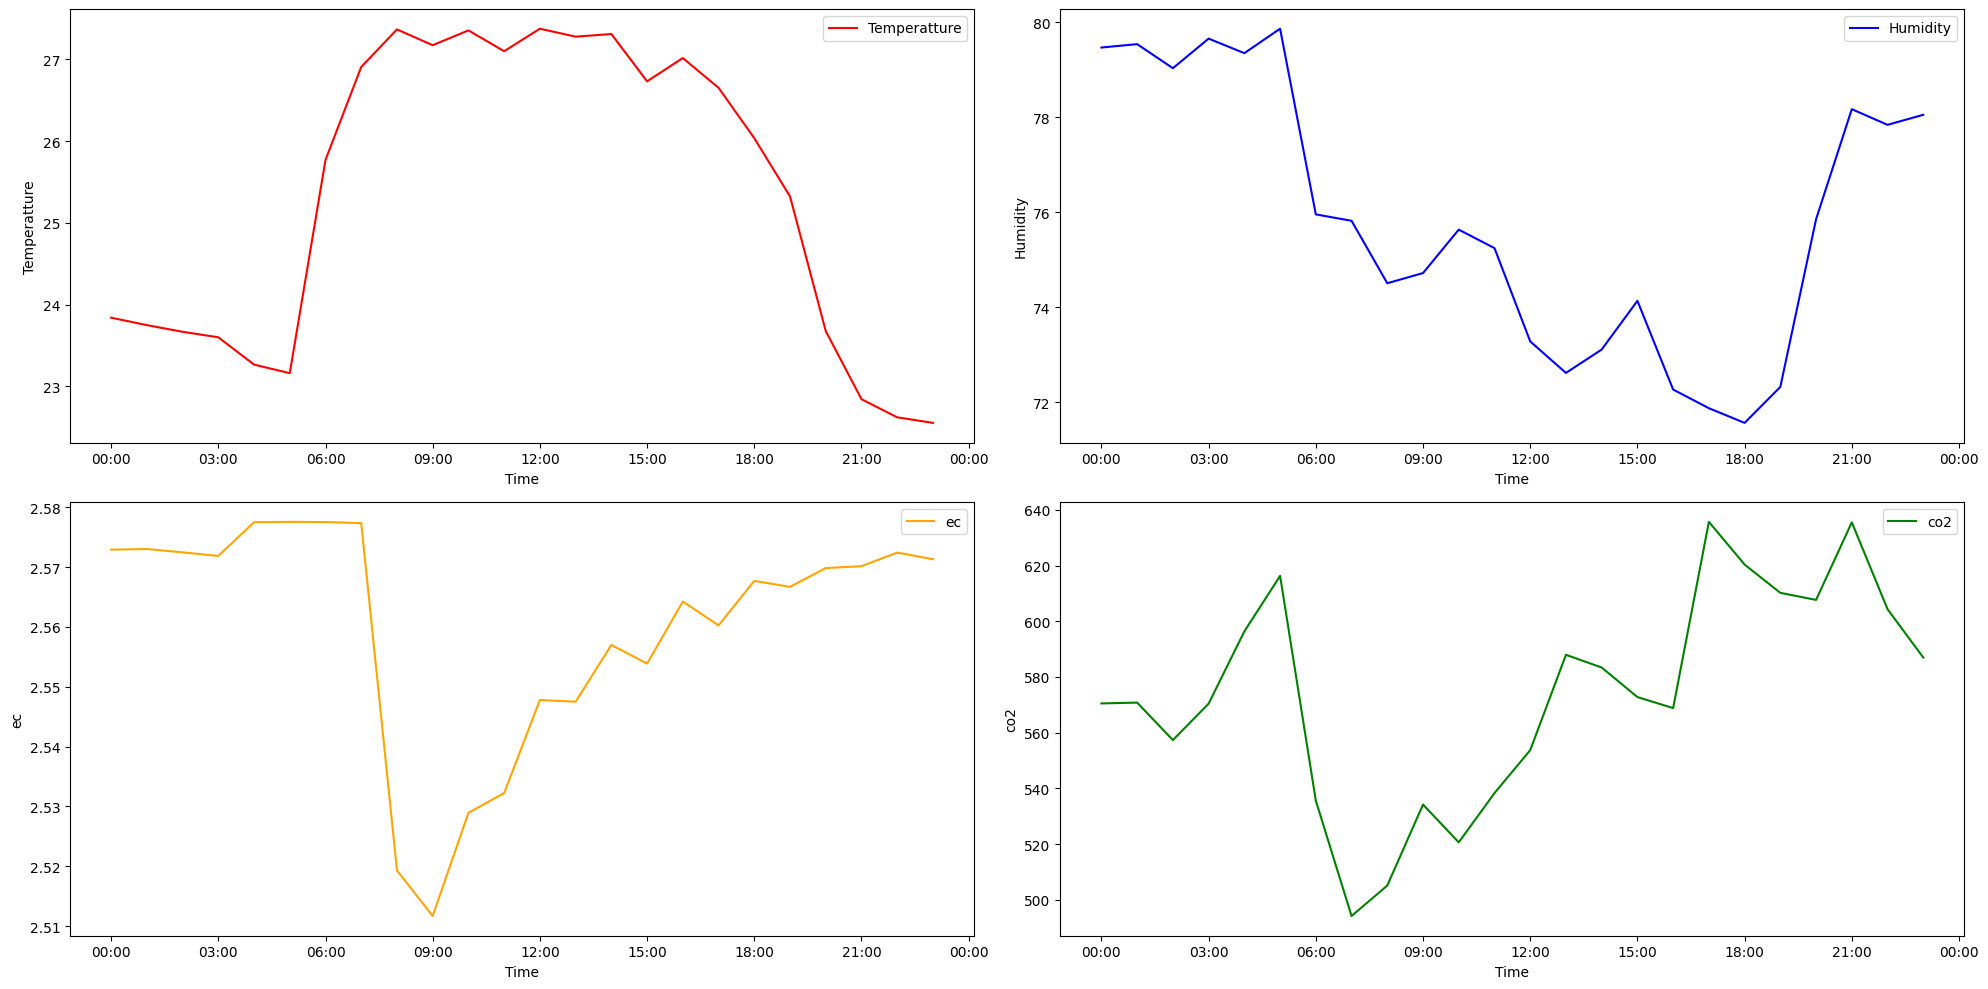

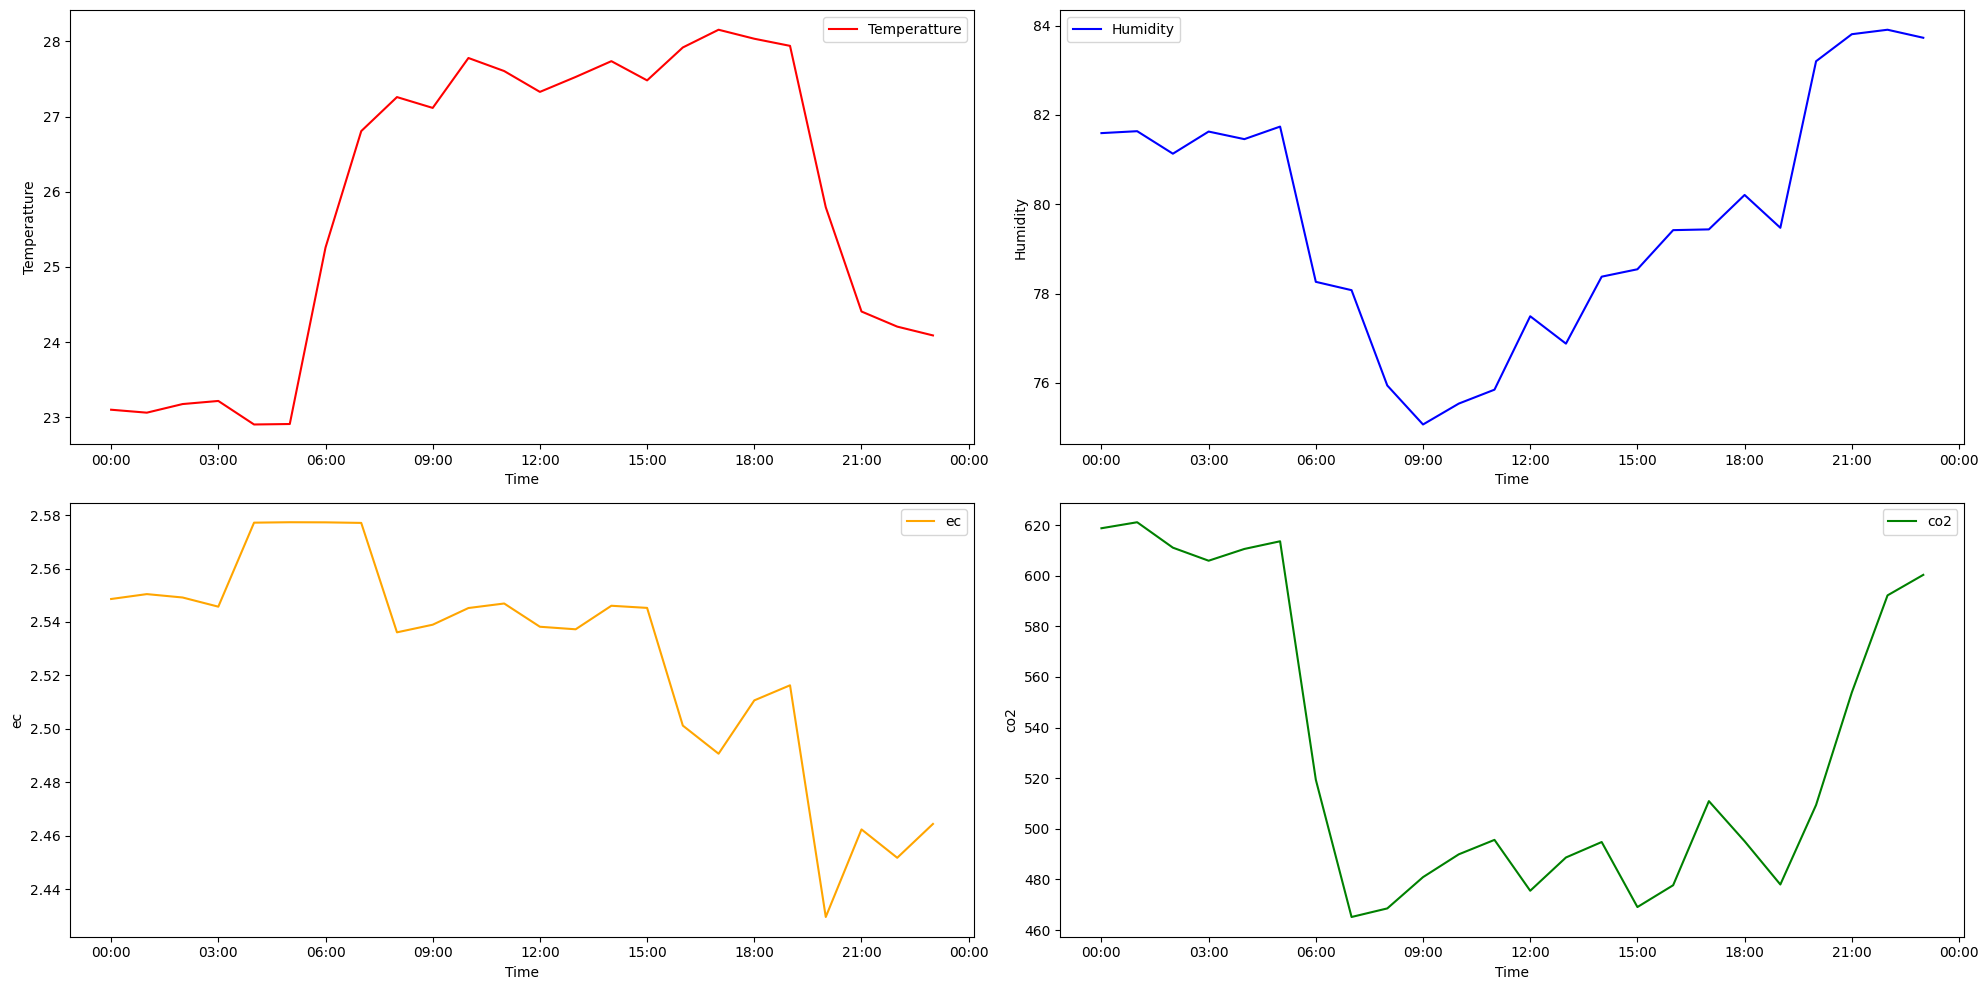

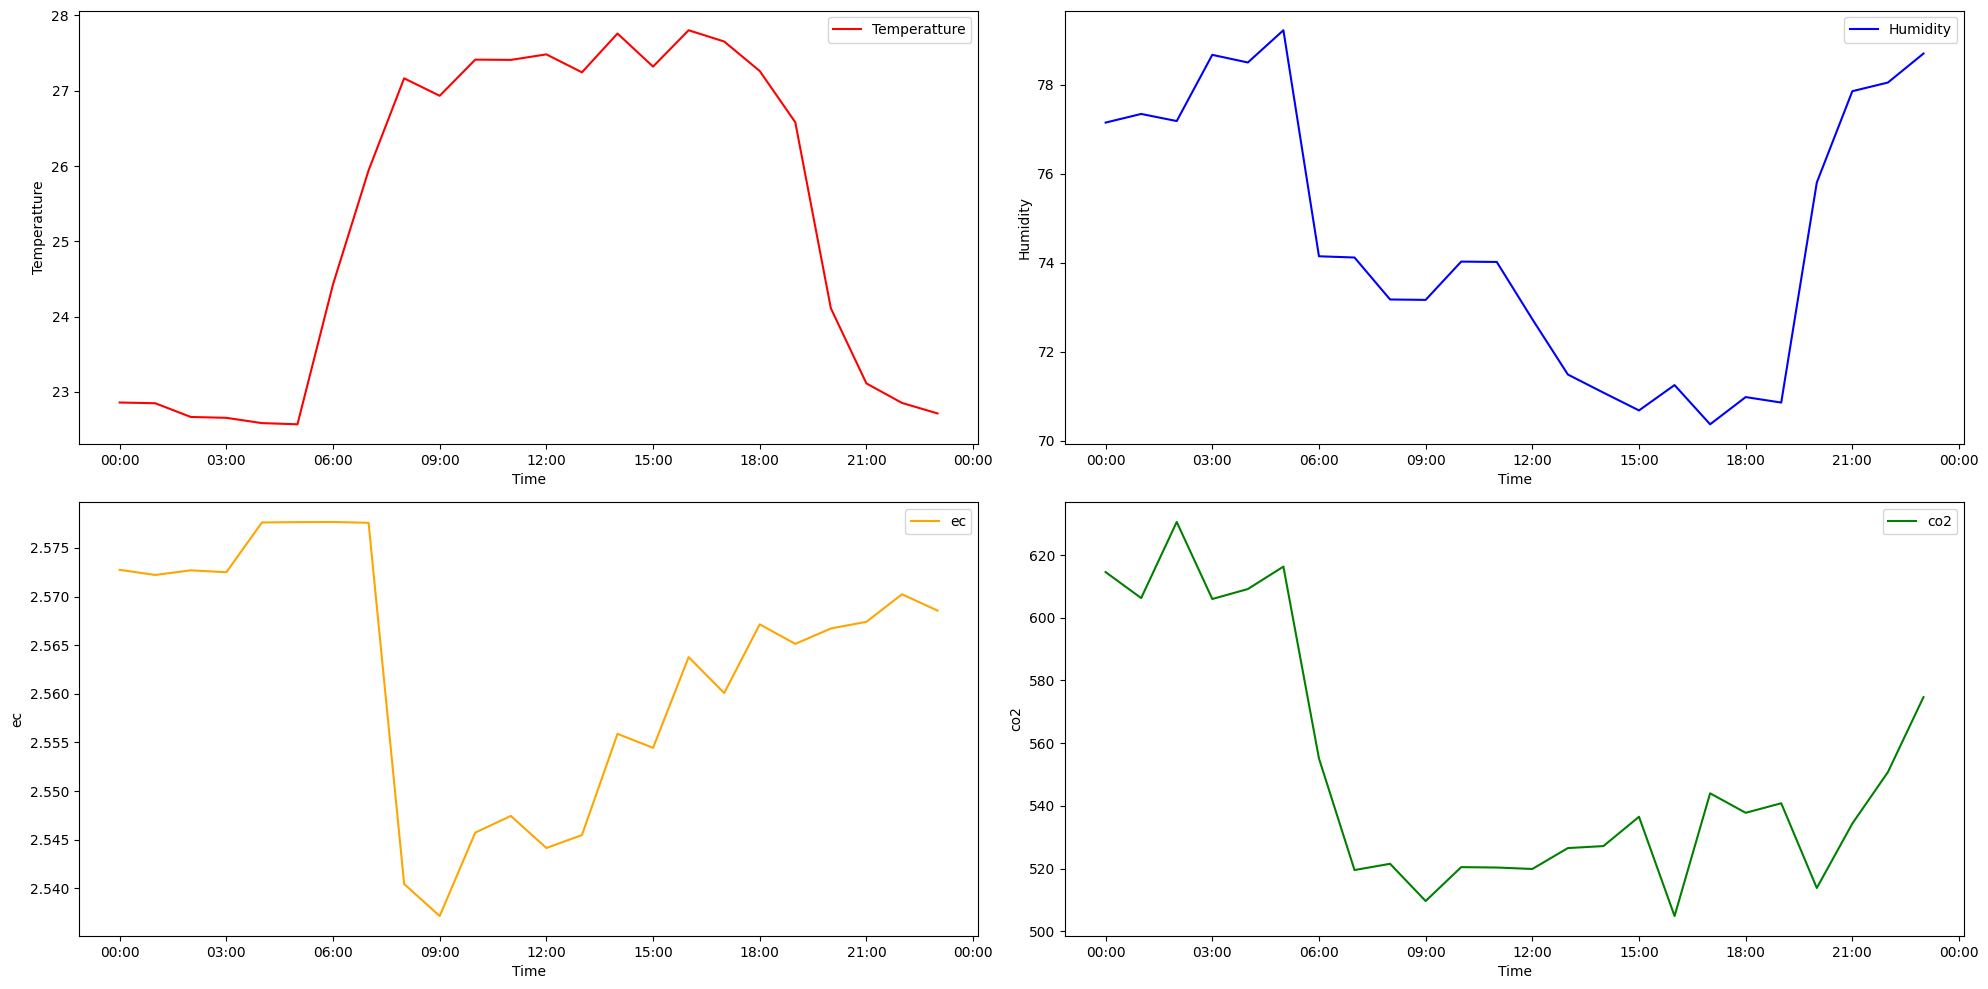

In [ ]:
plot_day(synthetic_features1[20,:,:])
plot_day(synthetic_features1[5,:,:])
plot_day(synthetic_features1[12,:,:])

### 1-weak training samples
1. Train data: CASE_01~28.csv

In [ ]:
features_1w = train_df.drop(columns='datetime').to_numpy()
features_1w = features_1w.reshape(-1, 24*7, features_1w.shape[1])
print(features_1w.shape)

(112, 168, 4)


In [ ]:
# Train DGAN model
model2 = DGAN(DGANConfig(
    max_sequence_len=features_1w.shape[1],
    sample_len=24,
    batch_size=min(1000, features_1w.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model2.train_numpy(
    features_1w,
    feature_types=[OutputType.CONTINUOUS] * features_1w.shape[2],
)


In [ ]:
# Generate synthetic data
_, synthetic_features_1w = model2.generate_numpy(1000)

In [ ]:
# Show a few of the 1-weak training samples
xaxis_1weak = train_df["datetime"][0:24*7]

def plot_weak(f):
  columns = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  titles = ['Temperatture', 'Humidity', 'ec', 'co2']
  colors = ['red', 'blue', 'orange', 'green']

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
  axs = axs.ravel(order='C')
  for i, c in enumerate(columns):
    axs[i].plot(xaxis_1weak, f[:,i], label=titles[i], color=colors[i])
    axs[i].legend()
    axs[i].xaxis.set_major_locator(md.HourLocator(byhour=range(0,24,12)))
    axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(titles[i])
  plt.tight_layout()
  plt.show()

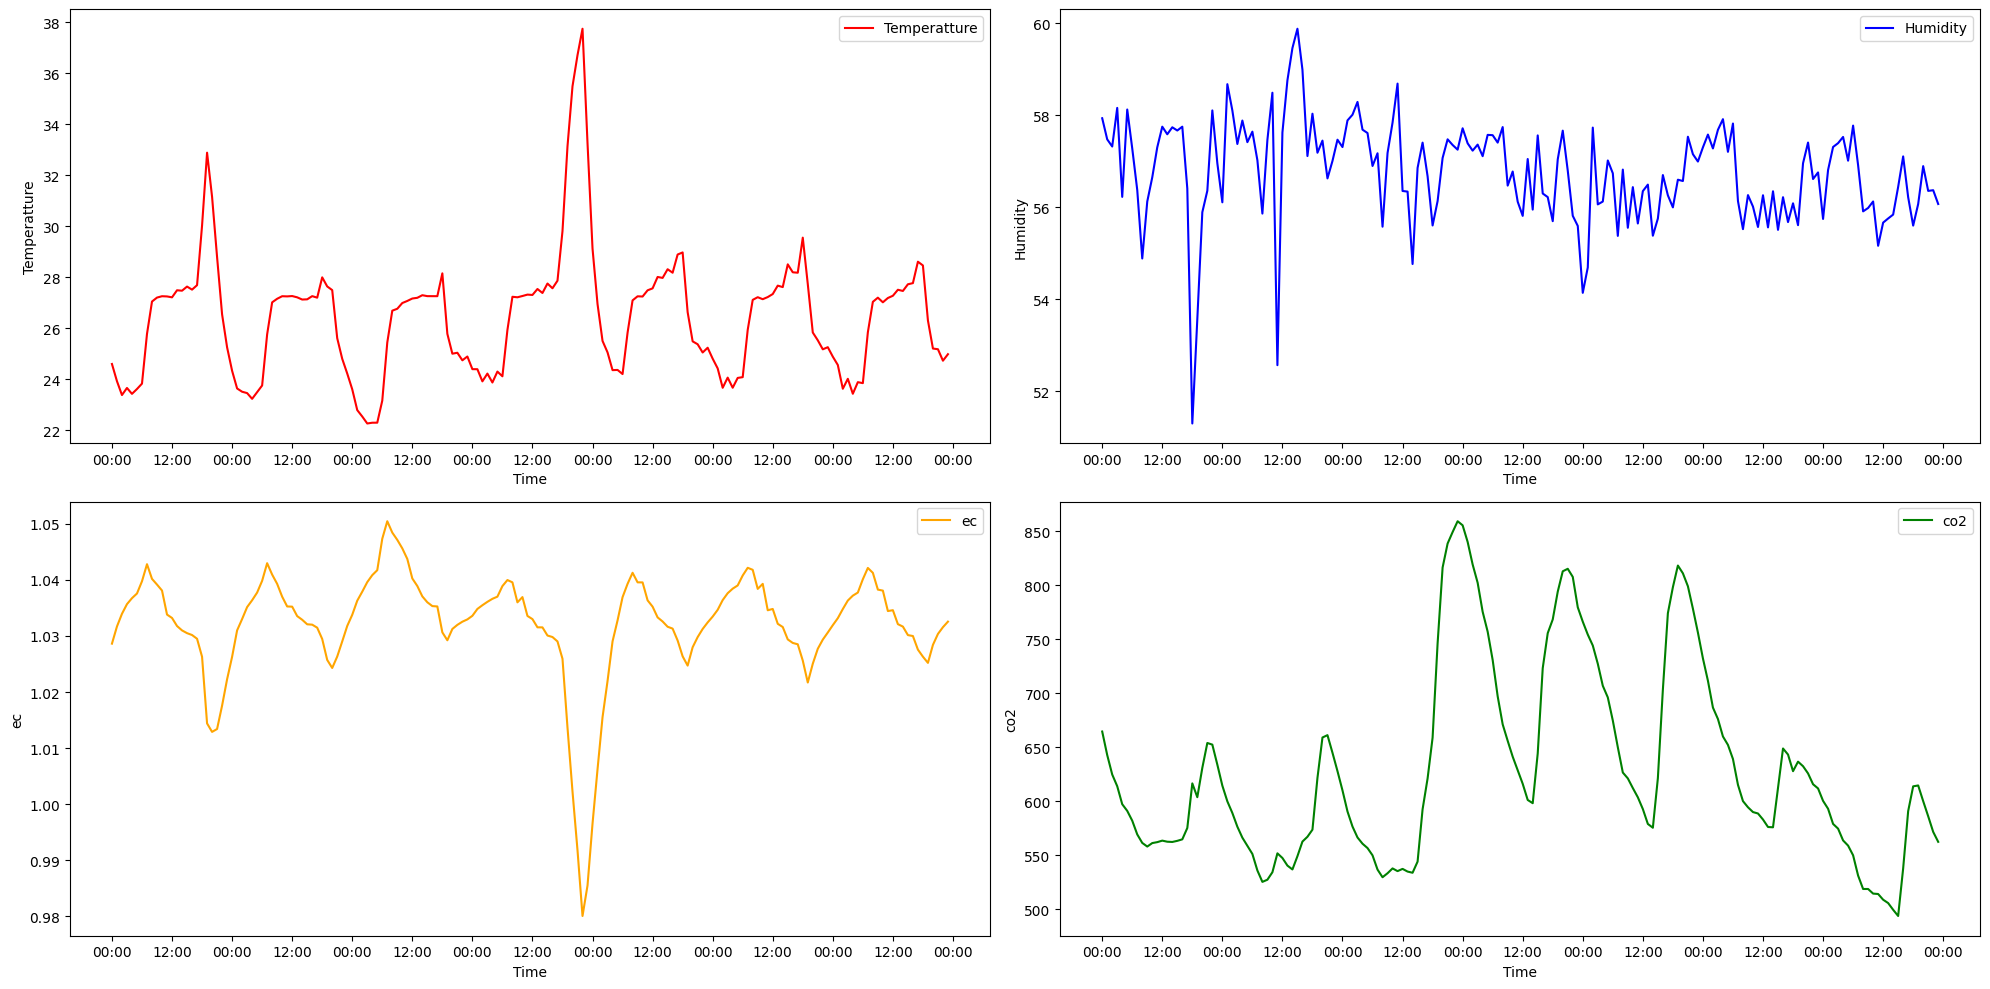

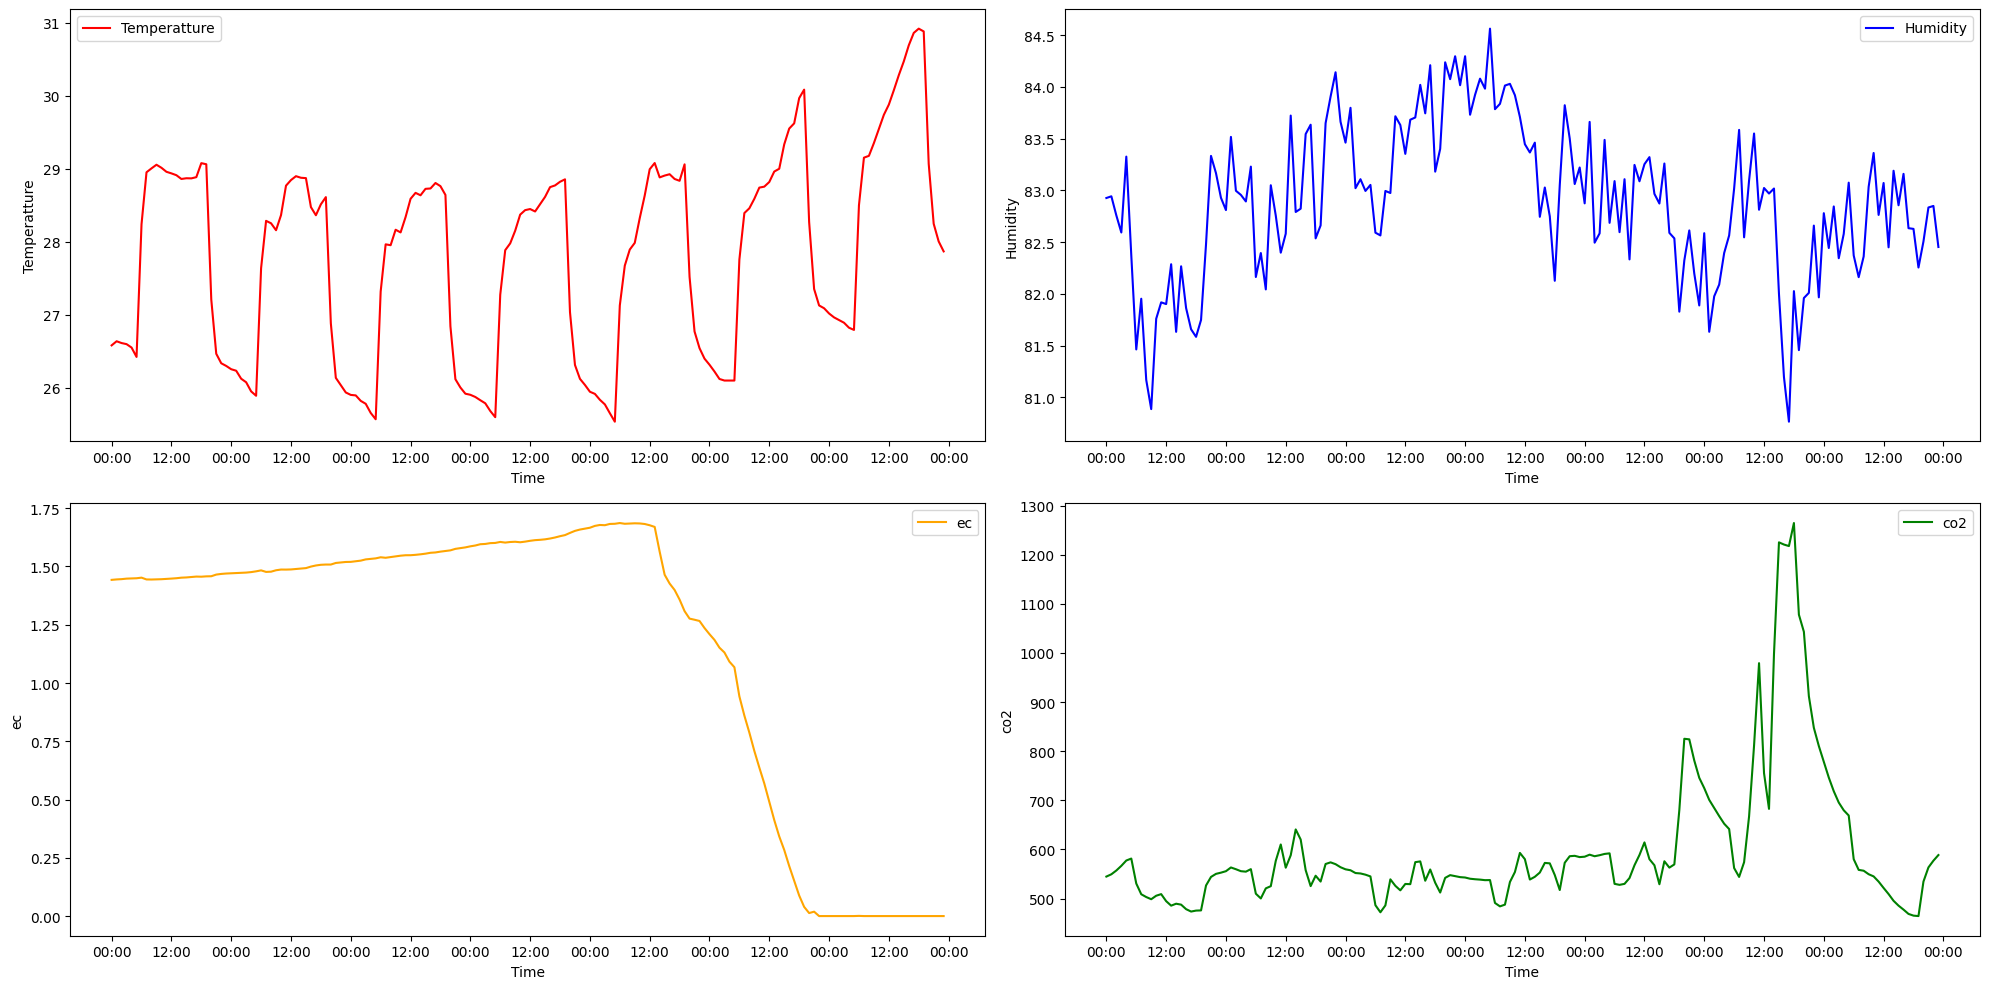

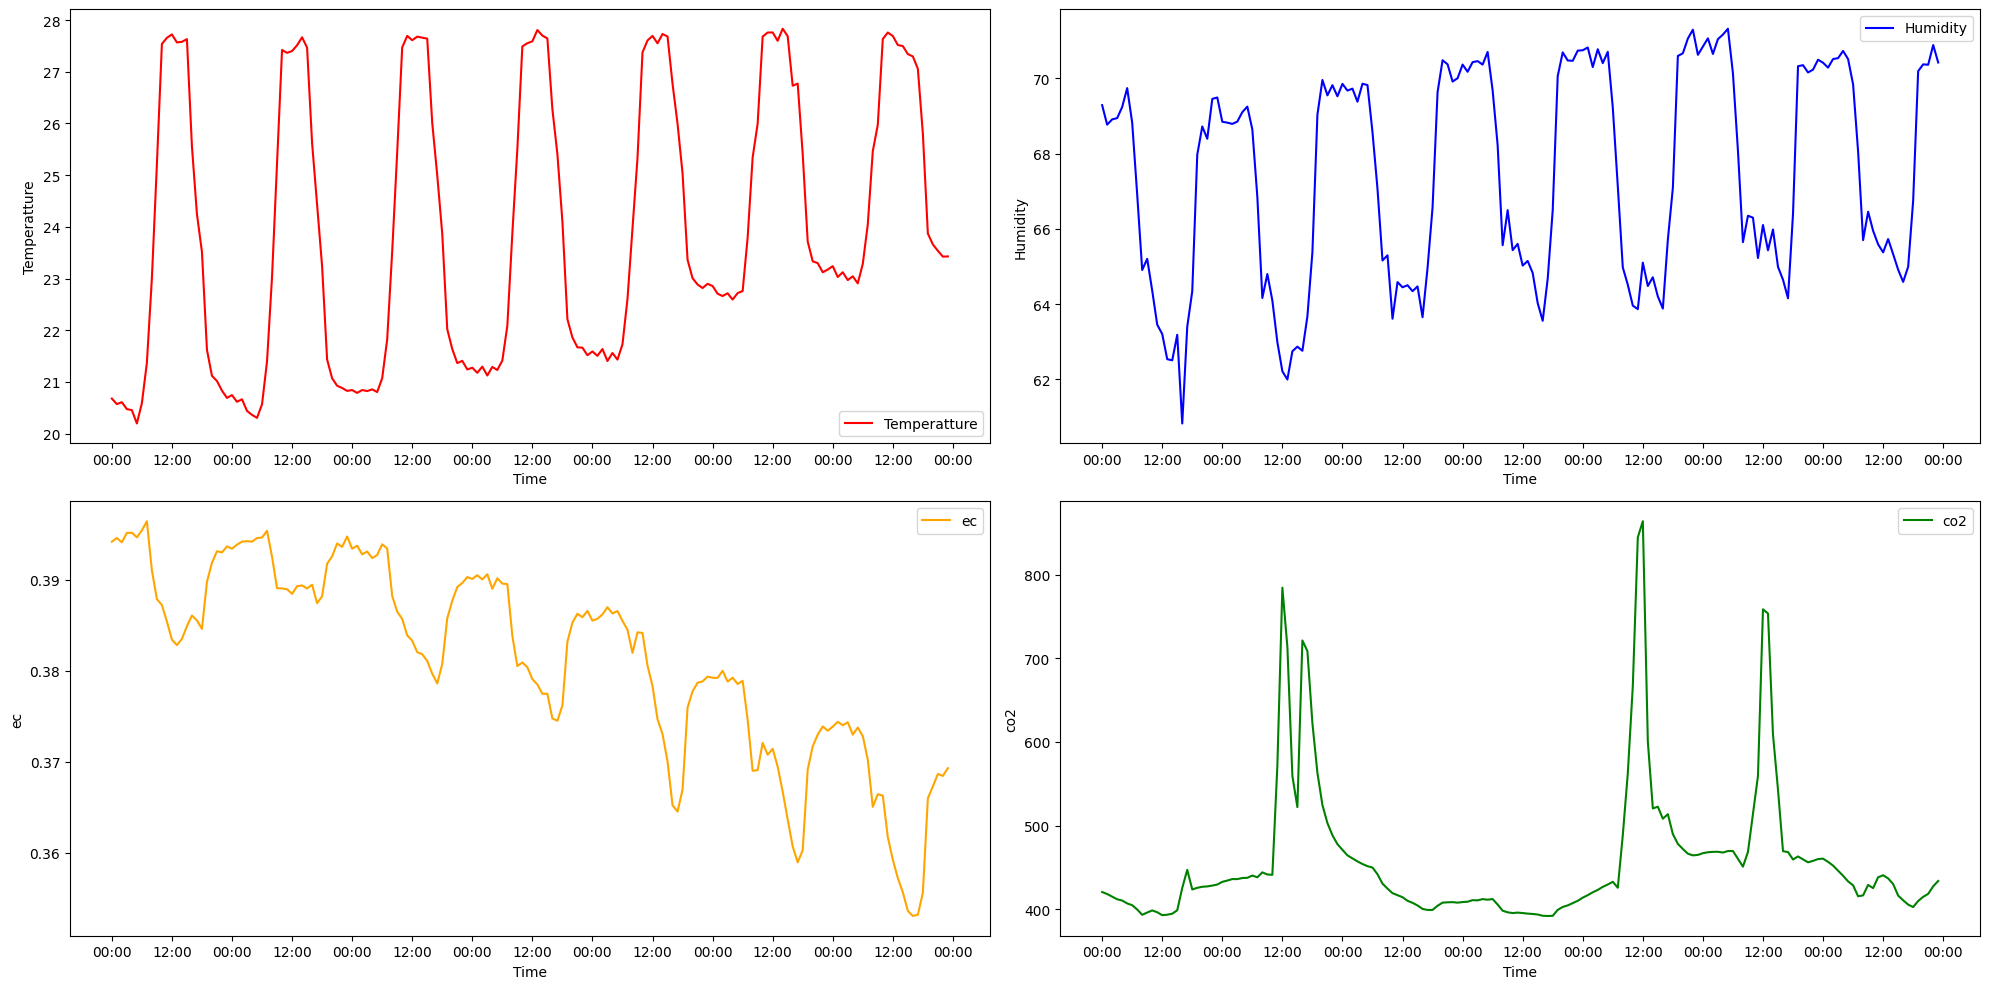

In [ ]:
%matplotlib inline
plot_weak(features_1w[101,:,:])
plot_weak(features_1w[3,:,:])
plot_weak(features_1w[21,:,:])

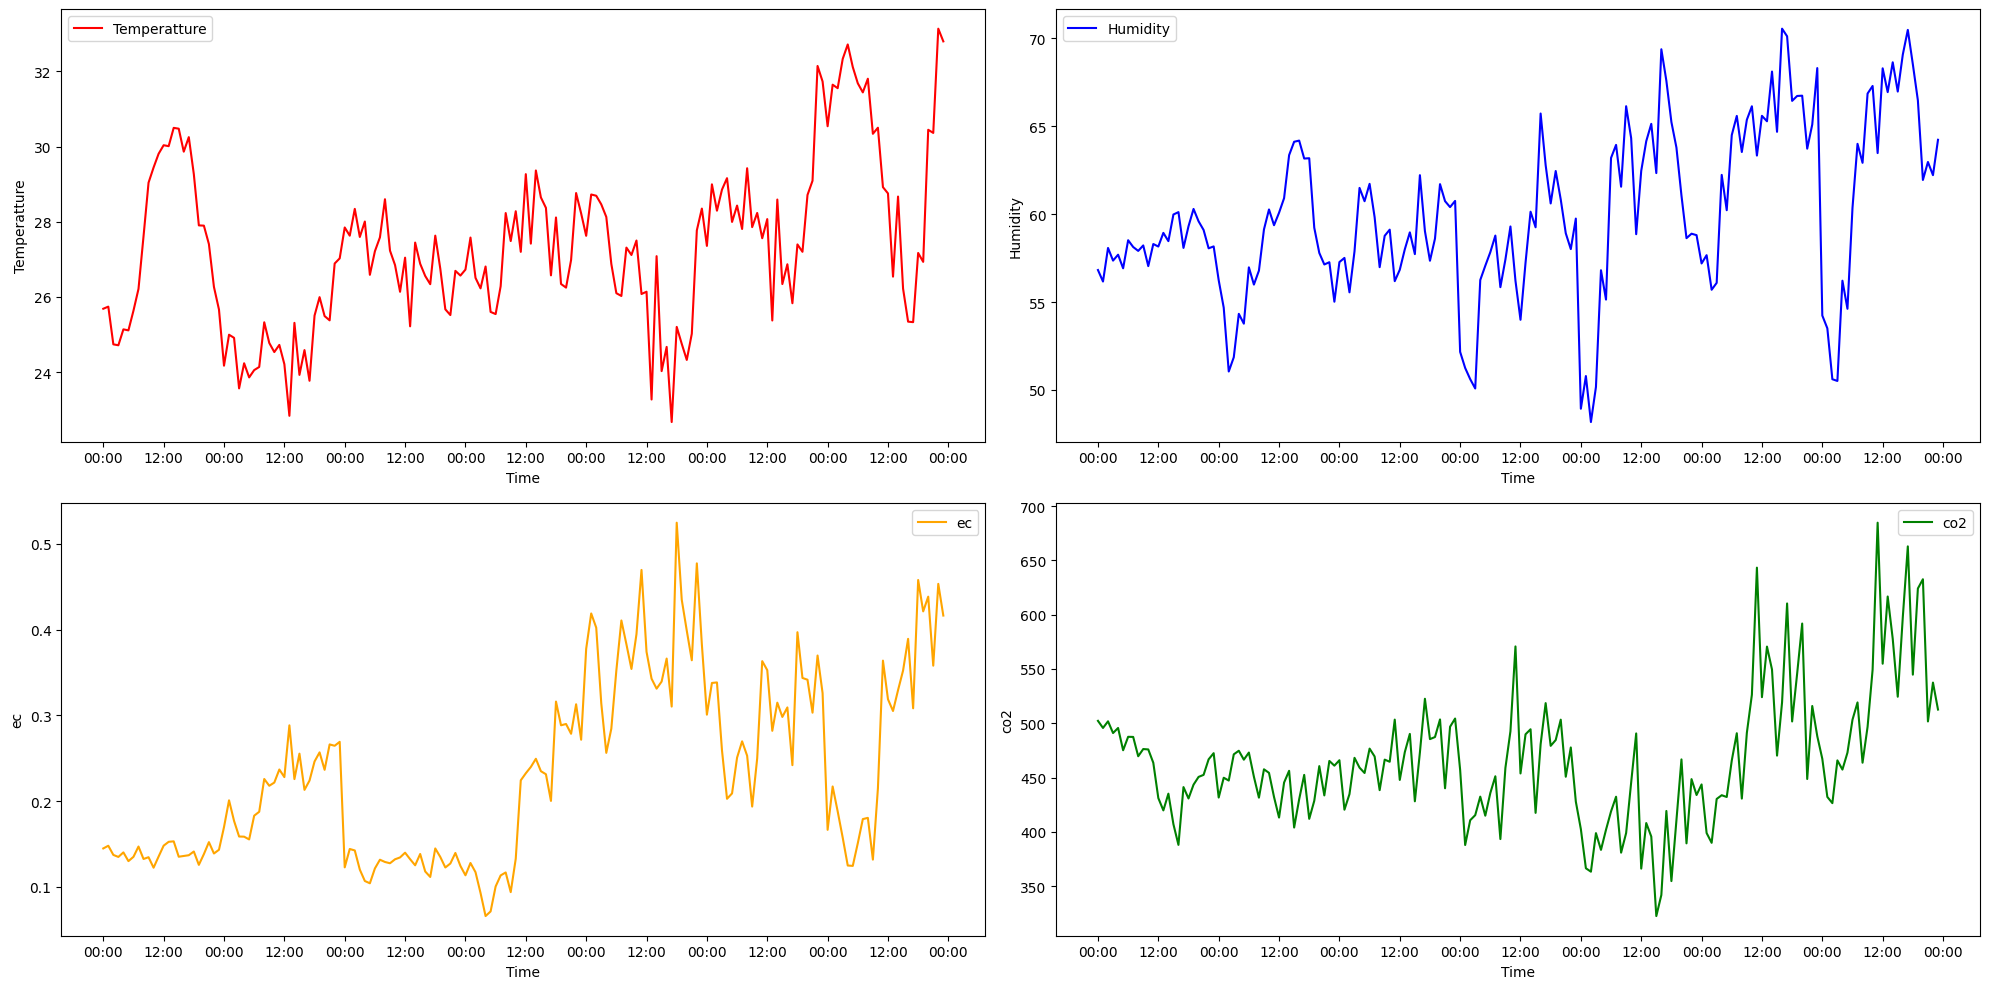

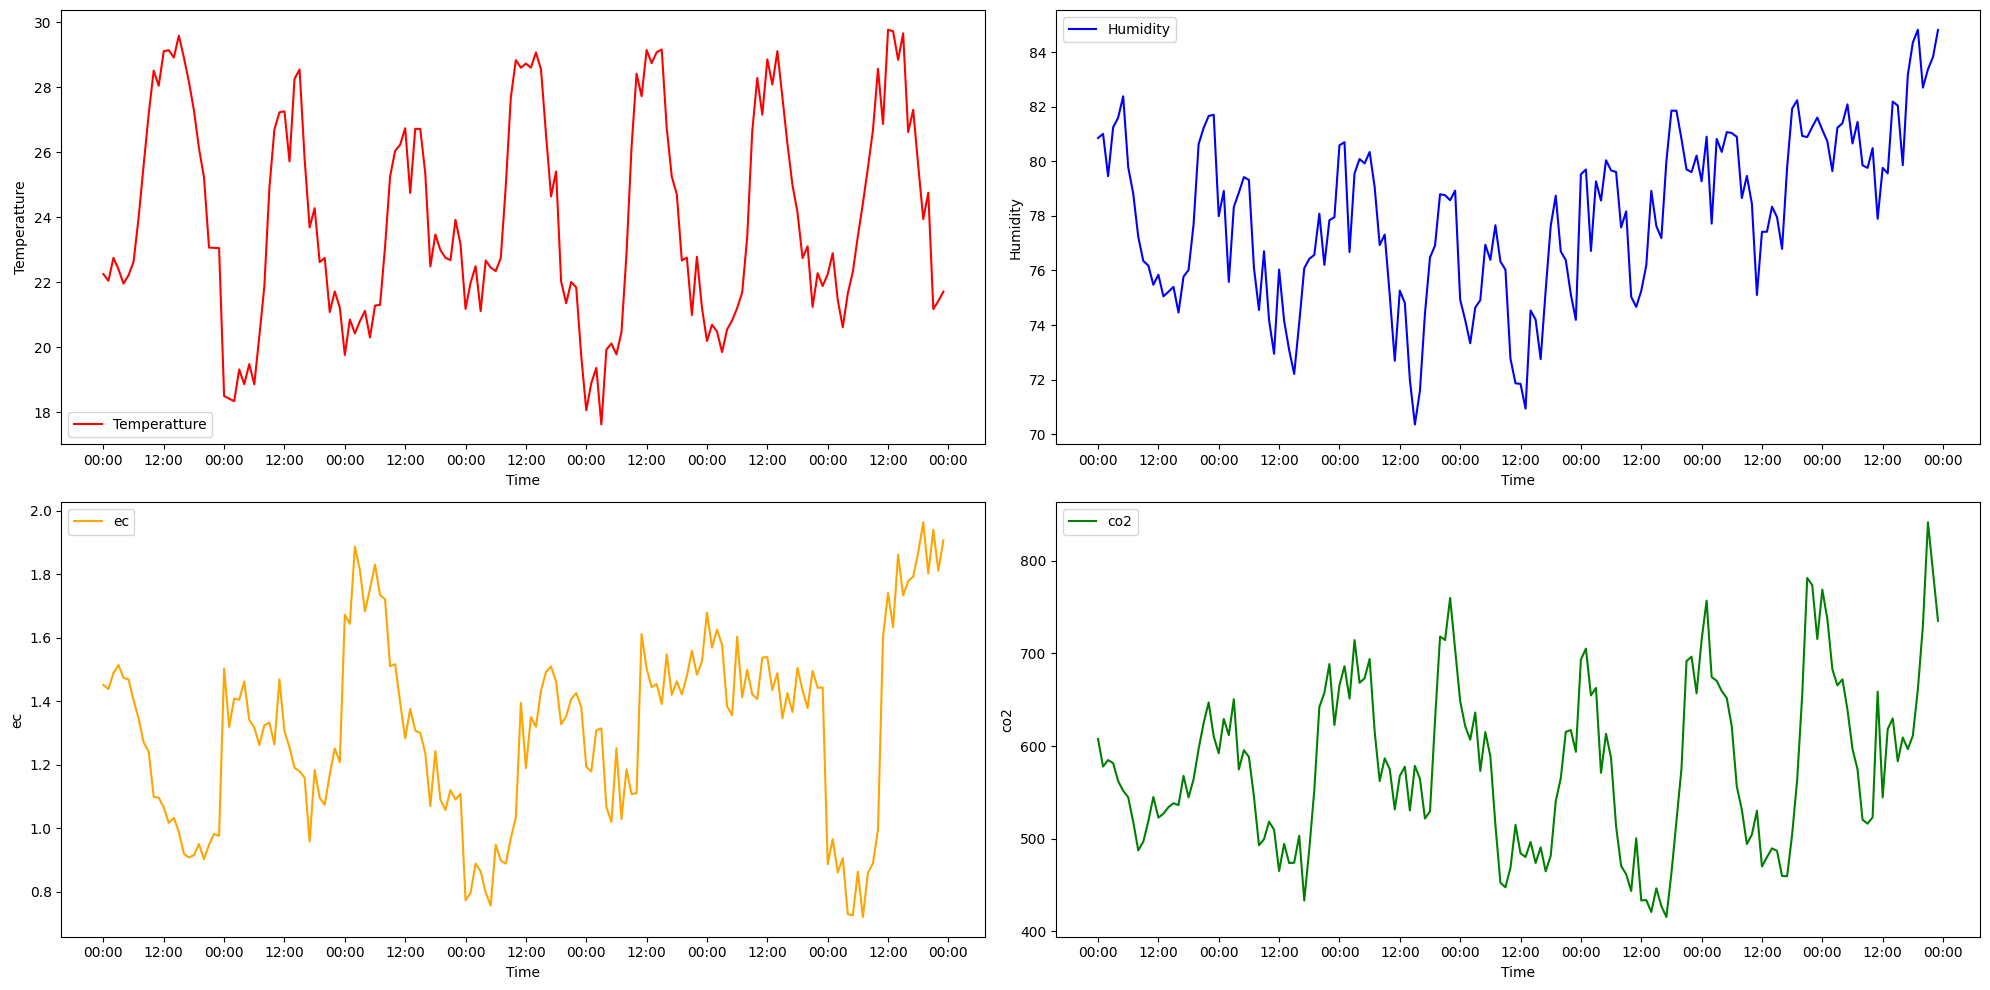

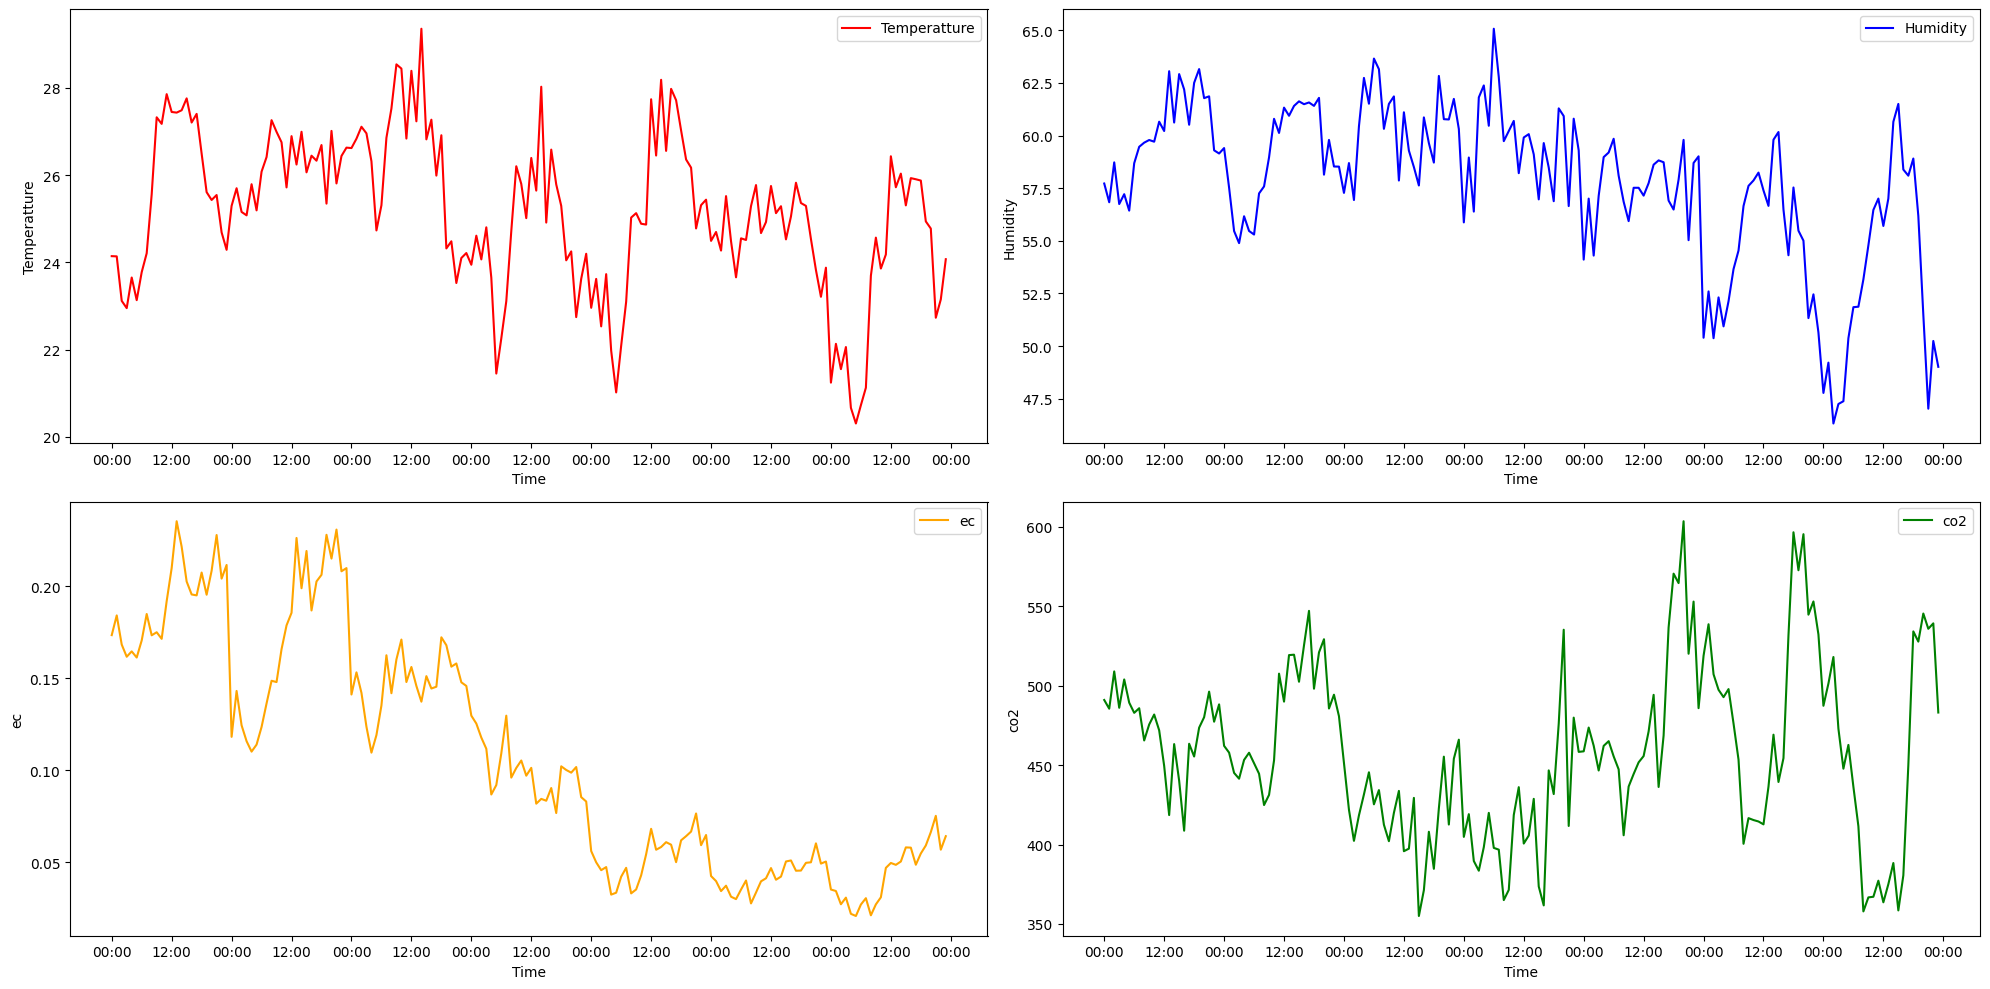

In [ ]:
# Show some synthetic 1-weak samples
plot_weak(synthetic_features_1w[825,:,:])
plot_weak(synthetic_features_1w[42,:,:])
plot_weak(synthetic_features_1w[496,:,:])

2. Train data: CASE_20.csv

In [ ]:
features1_1w = train_df1.drop(columns='datetime').to_numpy()
features1_1w = features1_1w.reshape(-1, 24*7, features1_1w.shape[1])
print(features1_1w.shape)

(4, 168, 4)


In [ ]:
# Train DGAN model
model3 = DGAN(DGANConfig(
    max_sequence_len=features1_1w.shape[1],
    sample_len=24,
    batch_size=min(1000, features1_1w.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
))

model3.train_numpy(
    features1_1w,
    feature_types=[OutputType.CONTINUOUS] * features1_1w.shape[2],
)


In [ ]:
# Generate synthetic data
_, synthetic_features1_1w = model3.generate_numpy(features1_1w.shape[0])
print(synthetic_features1_1w.shape)

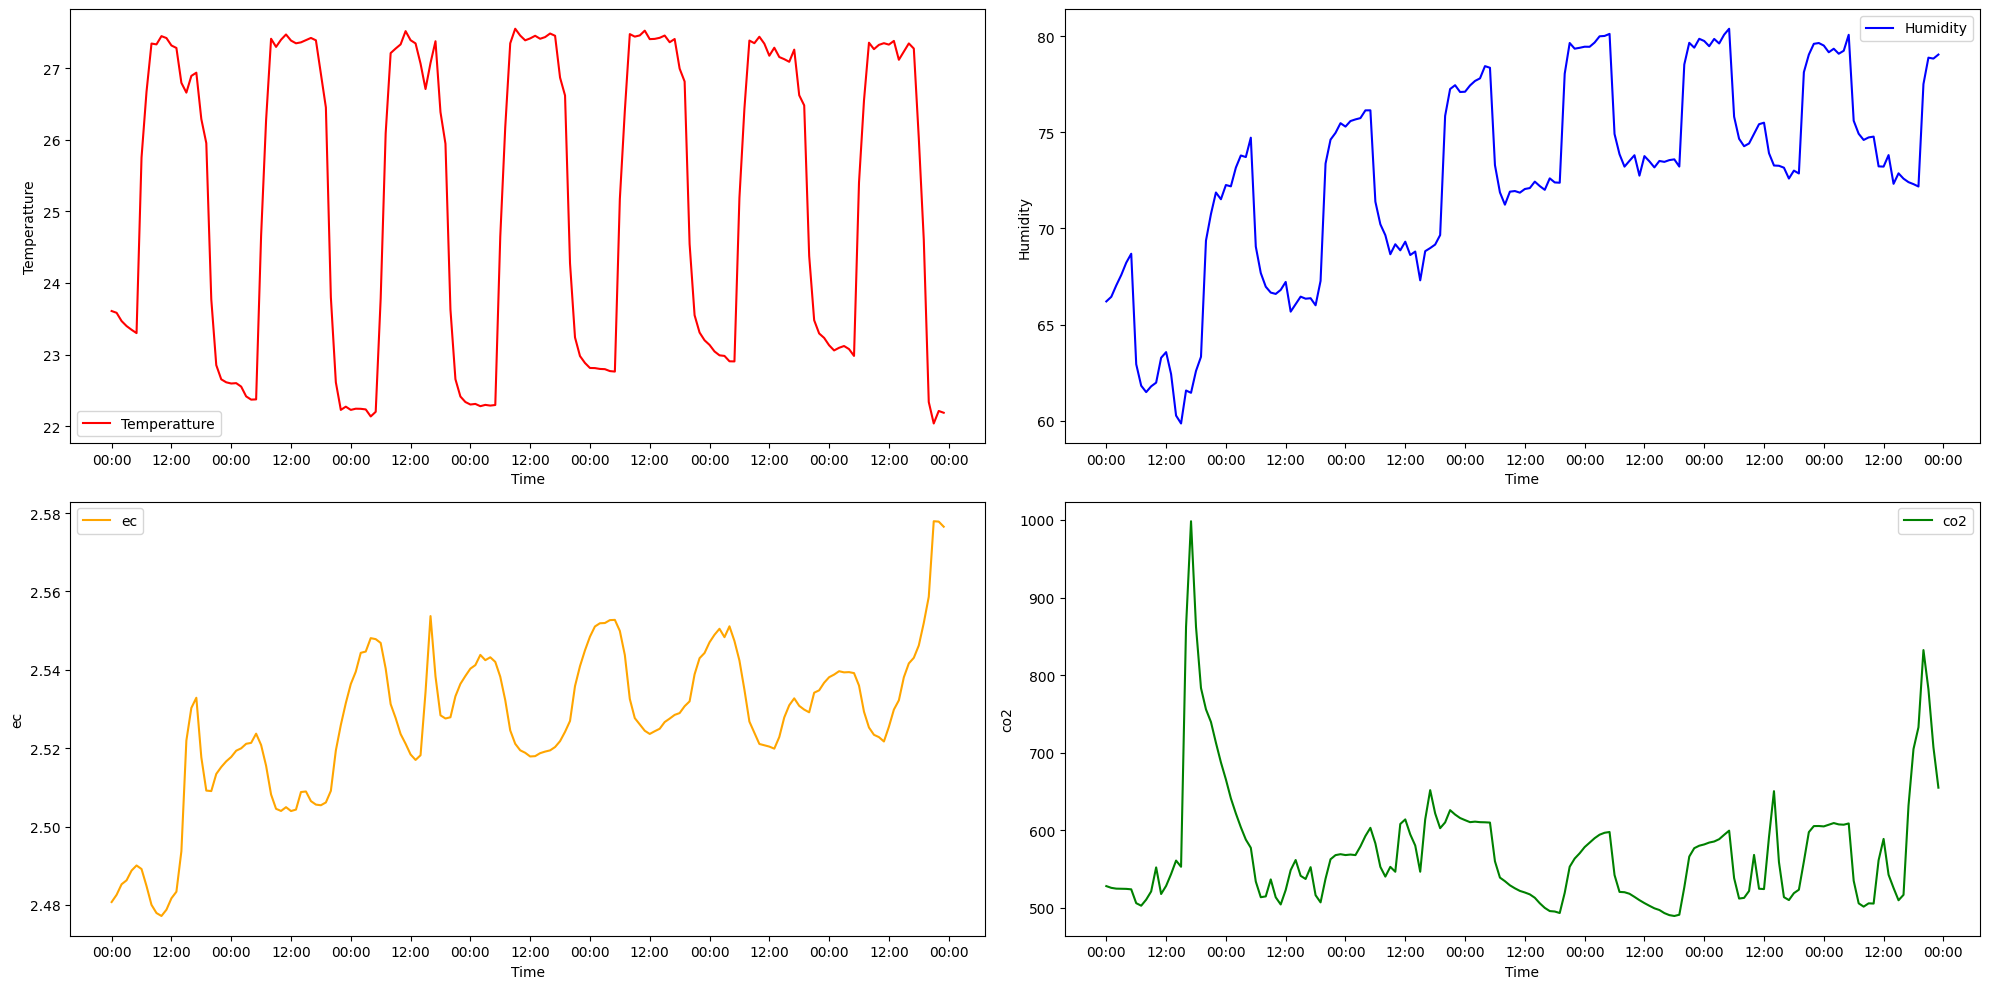

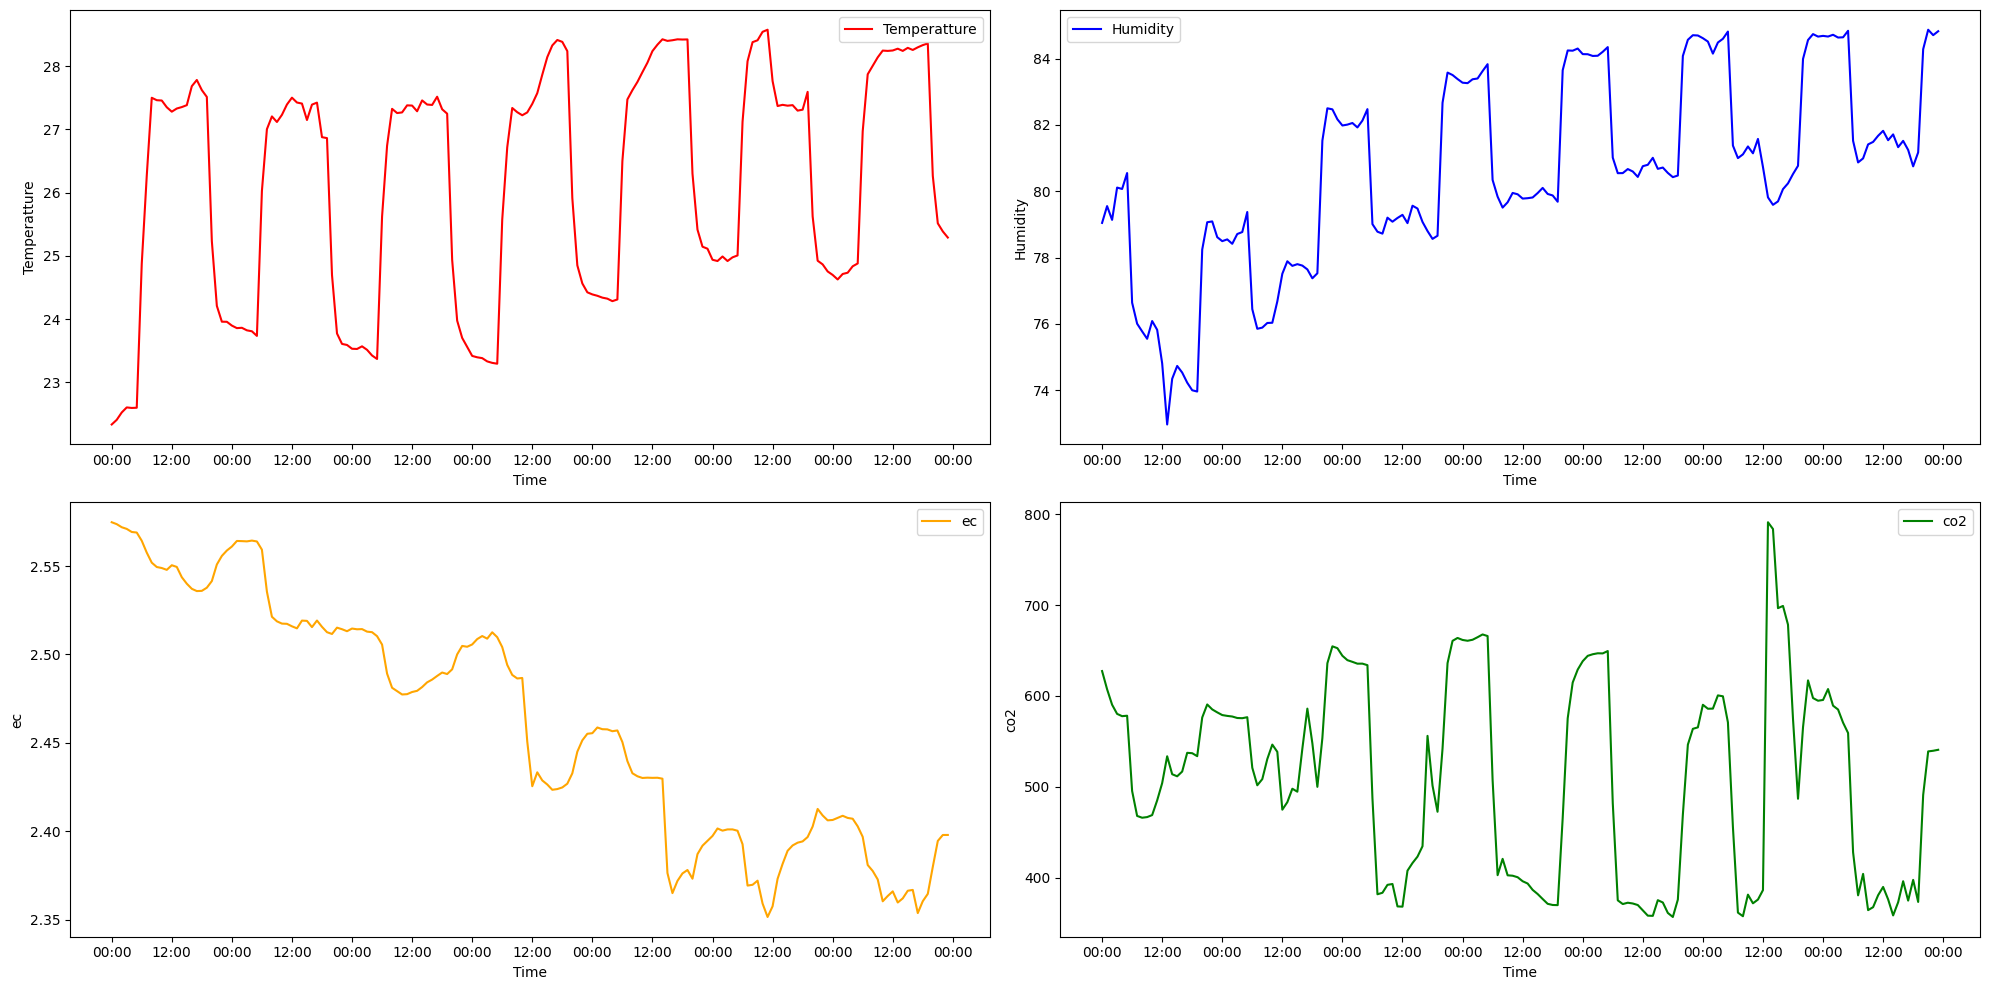

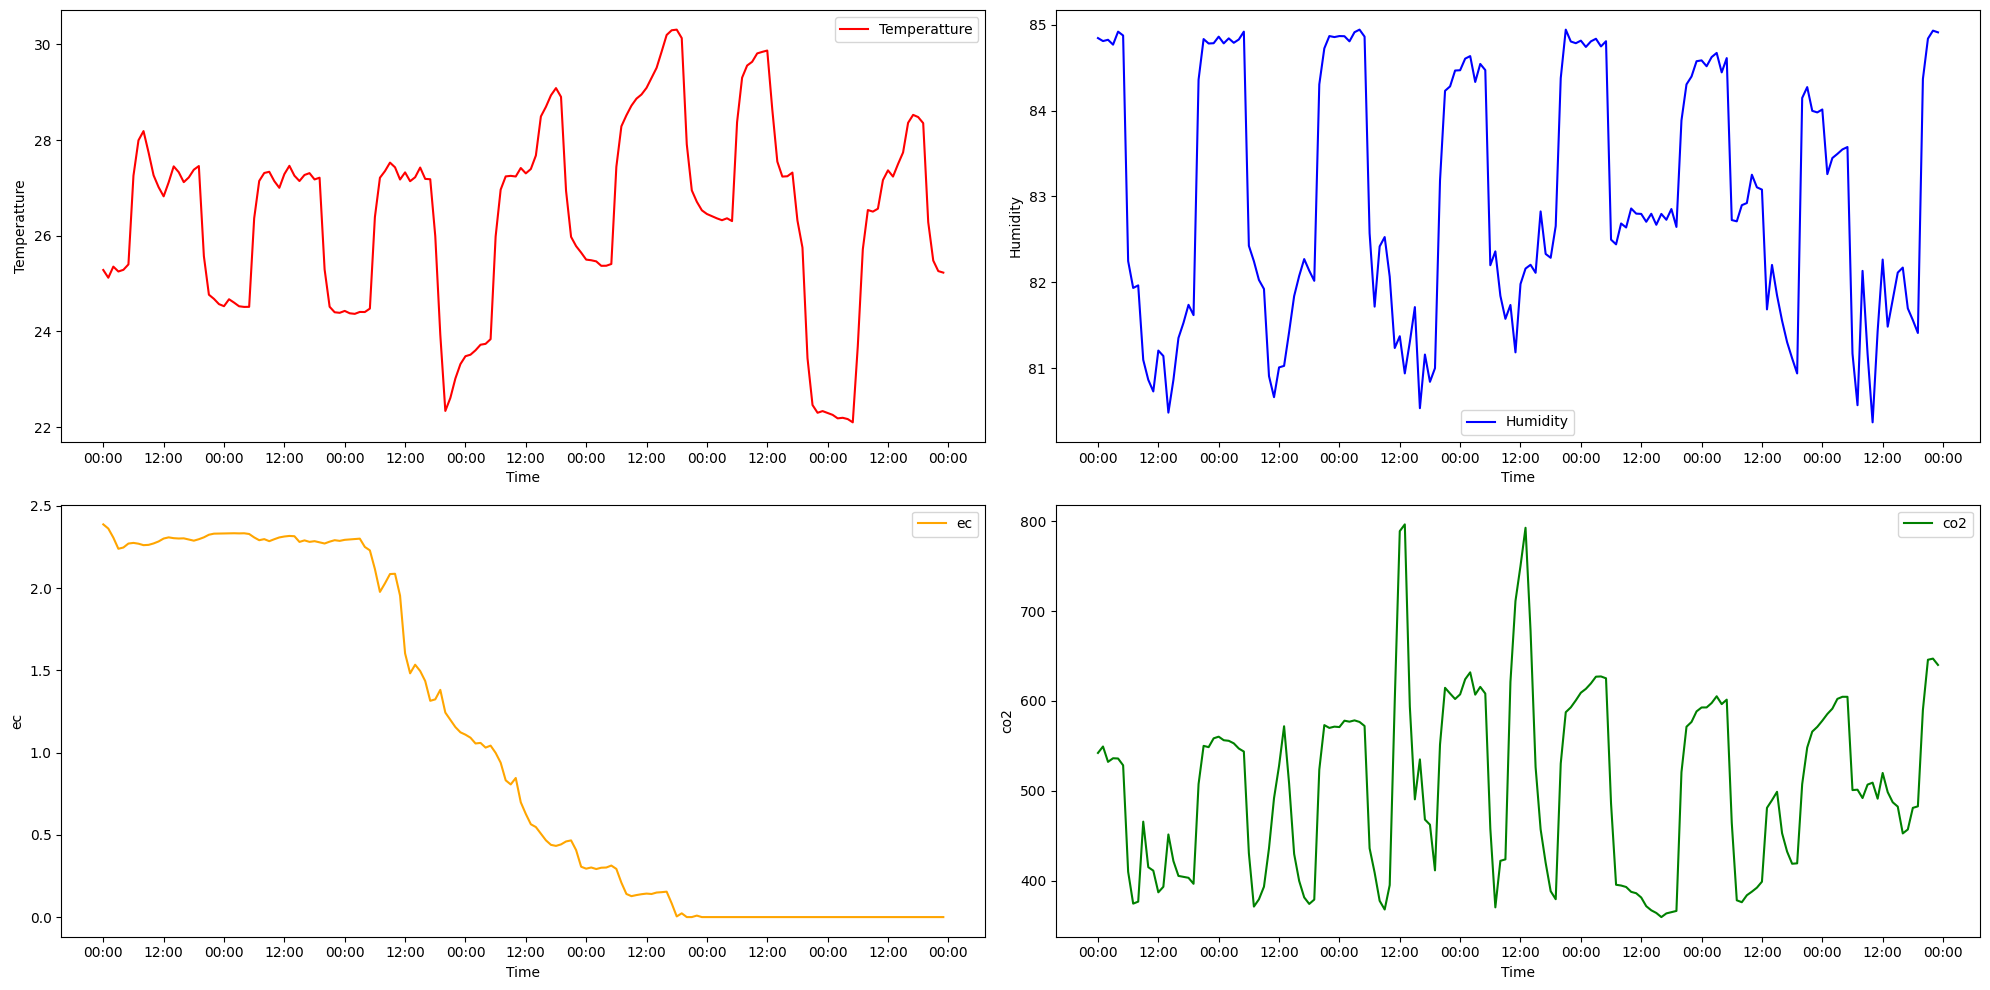

In [ ]:
# Show some real 1-weak samples
plot_weak(features1_1w[21,:,:])
plot_weak(features1_1w[2,:,:])
plot_weak(features1_1w[15,:,:])

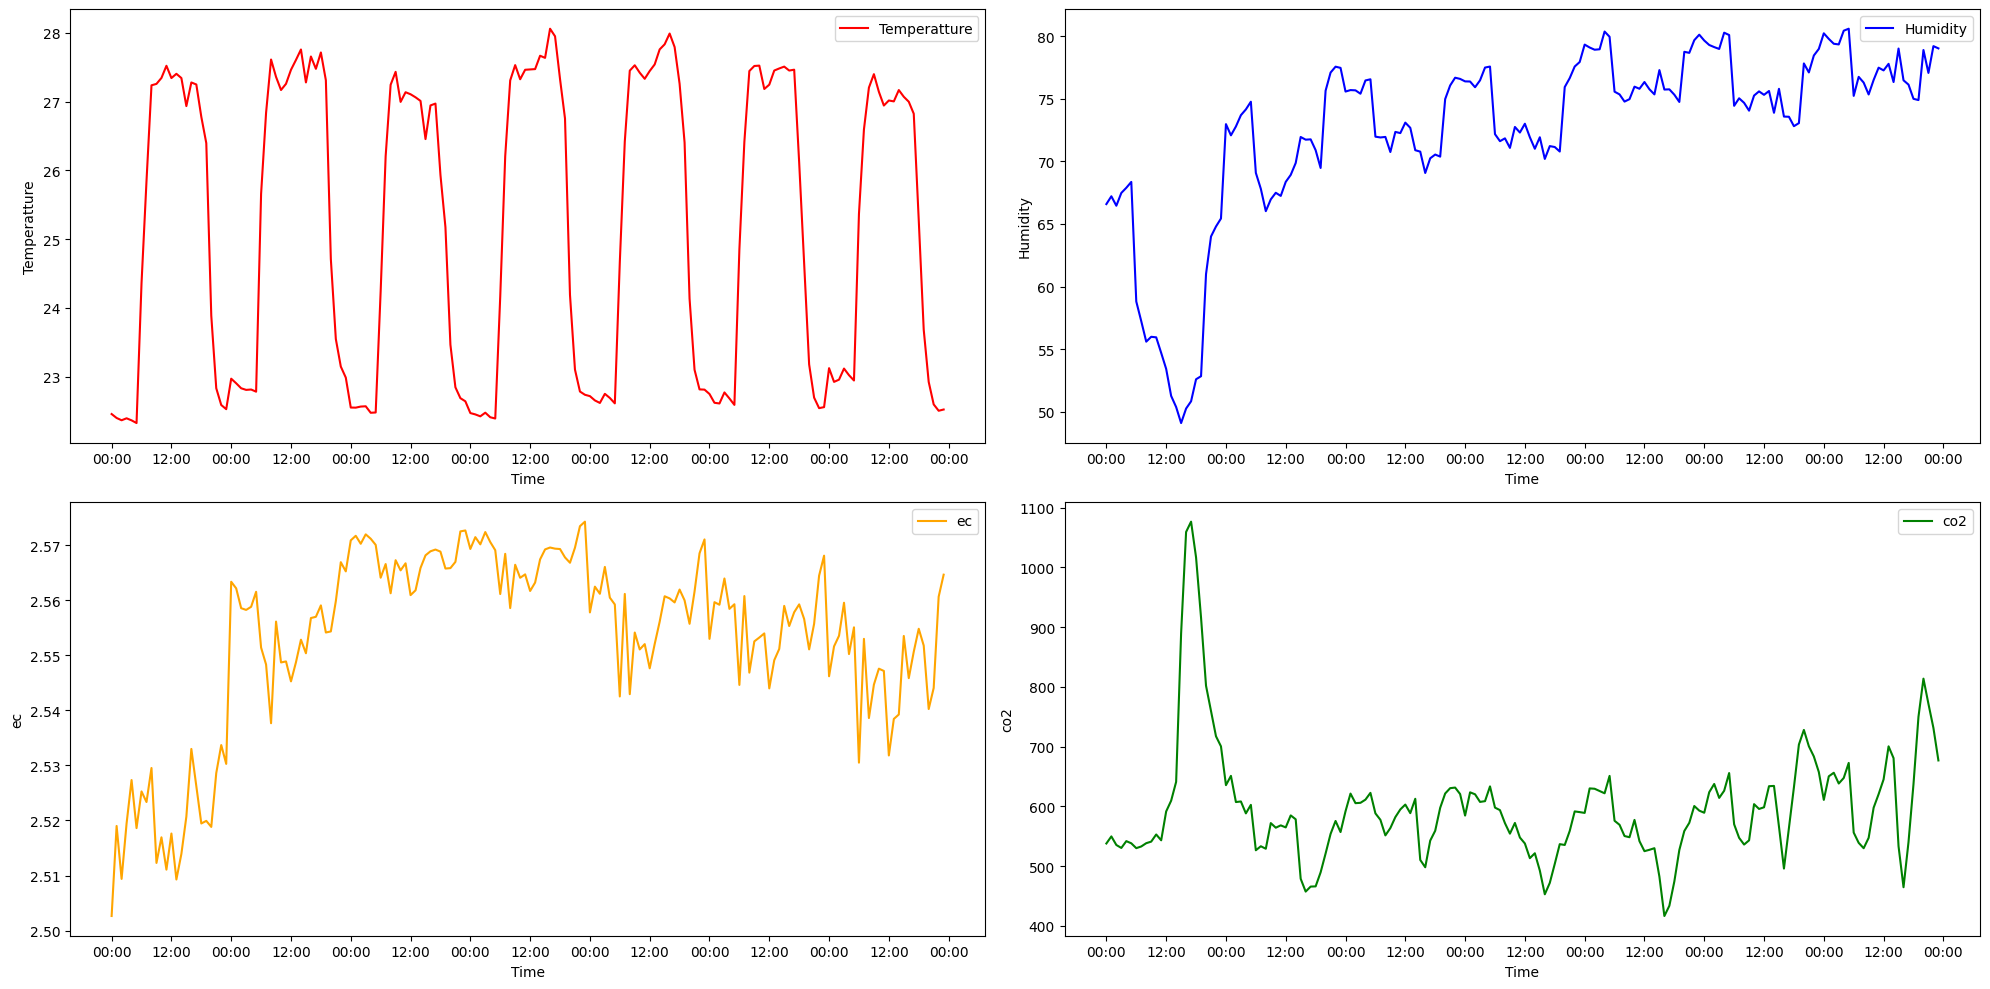

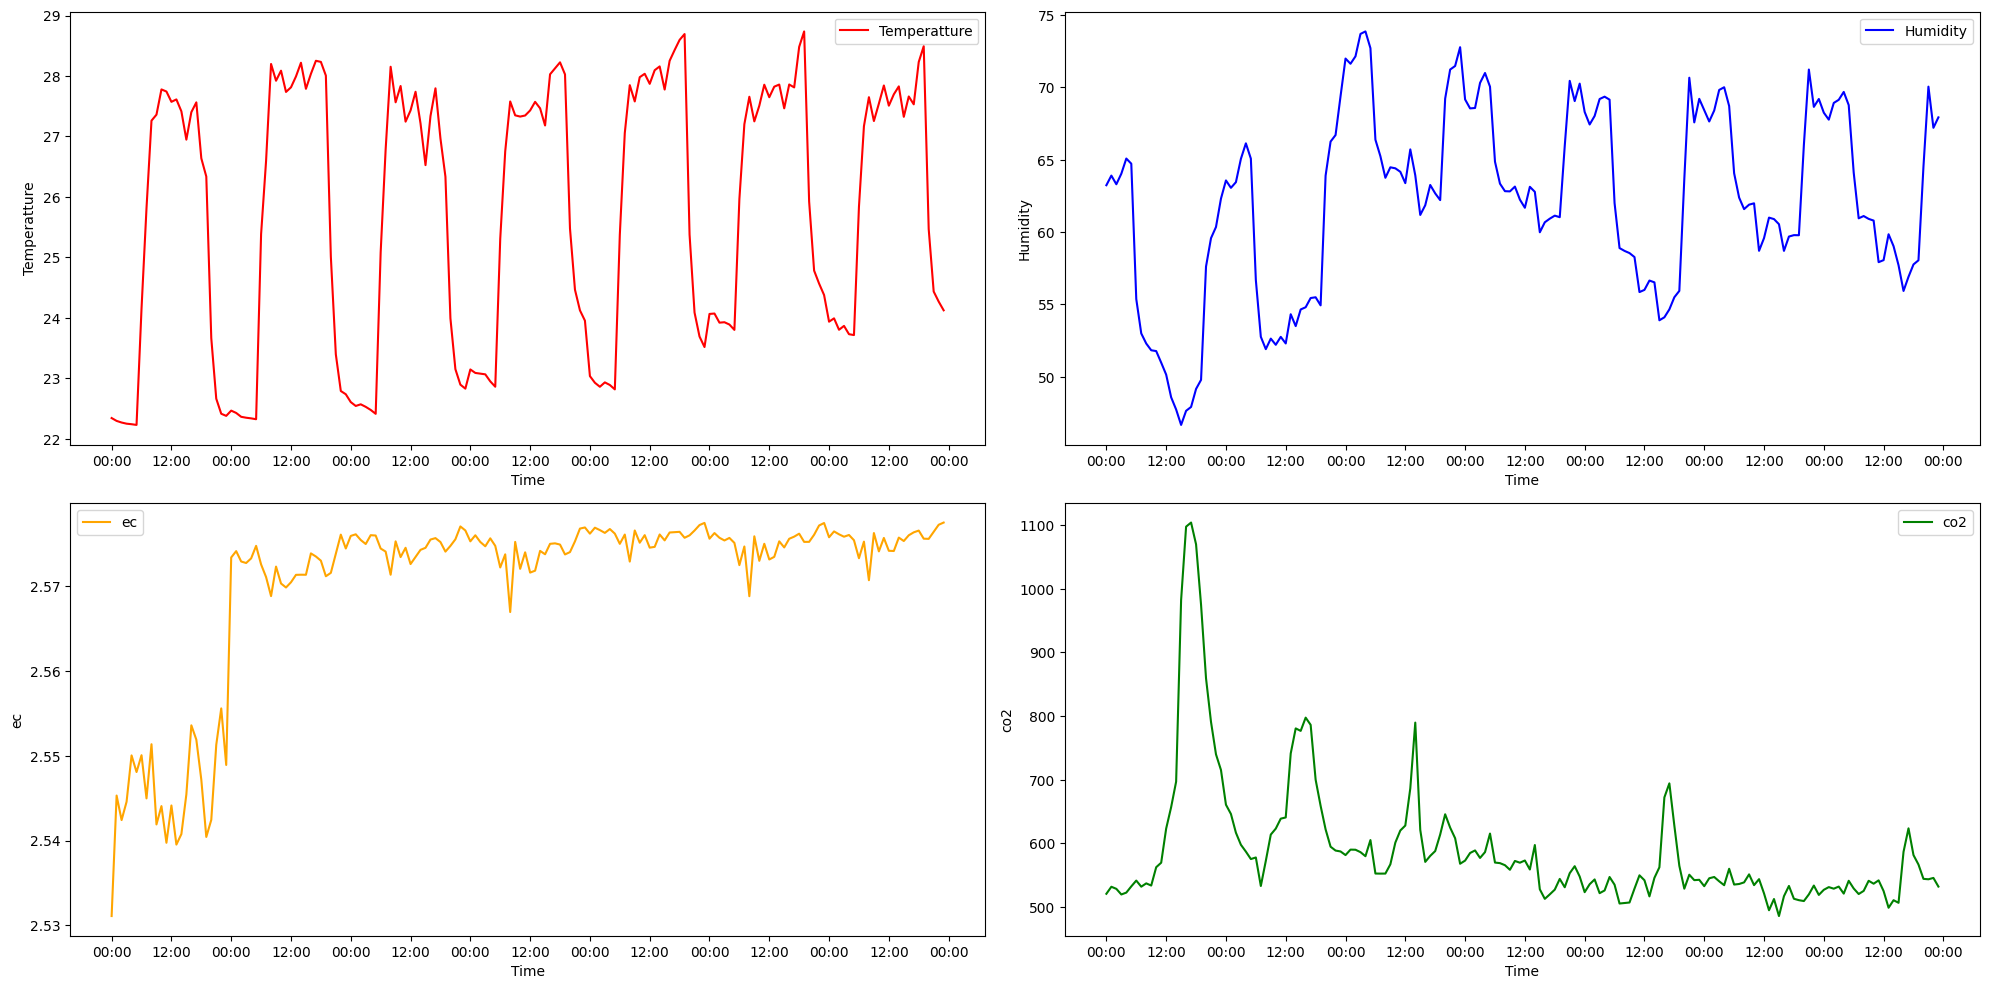

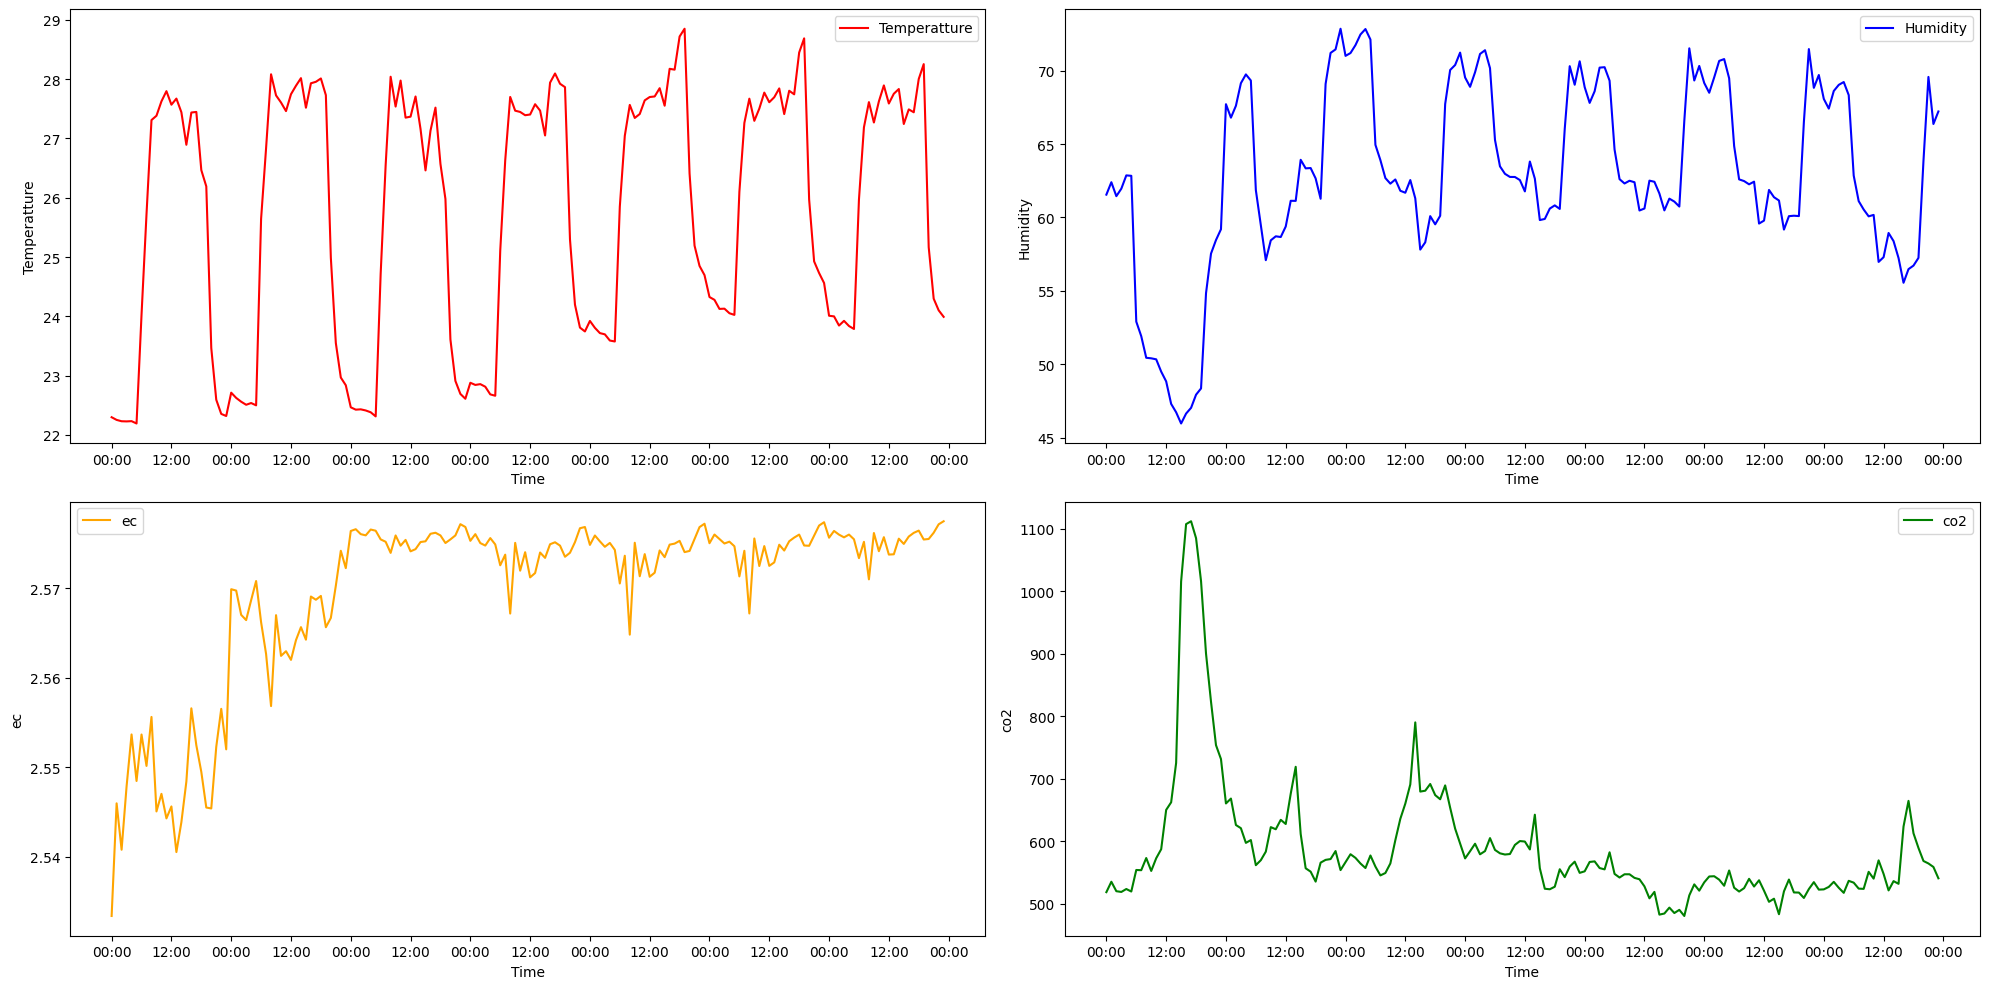

In [ ]:
# Show some synthetic 1-weak samples
plot_weak(synthetic_features1_1w[21,:,:])
plot_weak(synthetic_features1_1w[2,:,:])
plot_weak(synthetic_features1_1w[15,:,:])